In [1]:
from lemaitre import georges
georges.setup_logger(level='DEBUG')
from lemaitre import bandpasses

filterlib = bandpasses.get_filterlib()

2025-08-22 16:00:04 DEBUG lemaitre.georges.logger - logger set to DEBUG level
2025-08-22 16:01:07 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/sparse_dot_mkl/_mkl_interface/__init__.py:147: RuntimeWarning: MKL_INTERFACE_LAYER value LP64,GNU invalid; set 'ILP64' or 'LP64'
  _warnings.warn(

2025-08-22 16:01:44 DEBUG lemaitre.bandpasses.flibs - found 1 versions of lemaitre filterlib in cache
2025-08-22 16:01:44 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.dbe7e2486759aa0fb2f9f3172b4be8ca2a4461db77271d85f279f2ac2aea0c8f.pkl


In [2]:
import skysurvey
import numpy as np
import sncosmo
import pandas
from src import *
from tqdm.auto import tqdm
import jax.numpy as jnp
import pickle

2025-08-22 16:02:20 INFO nacl.models.salt2.model.lightcurves - sparse_dot_mkl found. Building hessian should be faster.
2025-08-22 16:02:31 DEBUG lemaitre.bandpasses.flibs - found 1 versions of lemaitre filterlib in cache
2025-08-22 16:02:31 INFO lemaitre.bandpasses.flibs - loading lemaitre filterlib from /cfs/home/angi0819/.cache/bbf/lemaitre_flib.default.dbe7e2486759aa0fb2f9f3172b4be8ca2a4461db77271d85f279f2ac2aea0c8f.pkl
2025-08-22 16:02:49 INFO arviz.preview - arviz_base not installed
2025-08-22 16:02:49 INFO arviz.preview - arviz_stats not installed
2025-08-22 16:02:49 INFO arviz.preview - arviz_plots not installed
INFO:2025-08-22 16:02:53,025:jax._src.xla_bridge:867: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-08-22 16:02:53 INFO jax._src.xla_bridge - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or

import warnings
from iminuit.warnings import IMinuitWarning

warnings.filterwarnings("ignore", category=IMinuitWarning)

In [1]:
%matplotlib inline

In [2]:
survey_colors = dict(ZTF="tab:blue", SNLS="tab:orange", HSC="tab:green")

In [3]:
z_max = 0.11677295
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(name="2m++", H0=68.1, Om0=0.306)

In [4]:
from scipy.interpolate import interp1d
import numpy as np

dc_to_z = interp1d(
    cosmo.comoving_distance(np.linspace(1e-4, 0.9, 10000)),
    np.linspace(1e-4, 0.9, 10000),
)

## Test georges

### Georges input formatting

In [8]:
lc_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/lc_data_0.parquet")

In [9]:
sn_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/sn_data_0.parquet")

In [9]:
spec_georges = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/mocks_madeleine/spec_data_0.parquet")

In [16]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [17]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc]) 

In [18]:
data.rename(columns={"t0":"tmax"}, inplace=True)
data.reset_index(drop=True, inplace=True)
data["IAU"]=np.NaN
data["valid"]=1
data["sig_int"]=0.


In [19]:
data[sn_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/sn_data_0.parquet")

In [20]:
lc.rename(columns=dict(time="mjd", zpsys="magsys"), inplace=True)

In [21]:
ids = lc.groupby(["sn", "band"]).flux.count()

In [22]:
ids = pandas.Series(data = np.arange(len(ids)), index= ids.index)

In [23]:
lc['lc'] = ids.loc[zip(lc.sn, lc.band)].values

In [24]:
lc[['mag_sky', 'seeing', 'exptime', 'ccd', 'amp',]] = np.NaN
lc['valid'] = 1
lc['errorsnake'] = 0.

In [25]:
lc['mjd_round'] = np.floor(lc.mjd)

In [26]:
lc.drop(columns=['fieldid', 'survey'], inplace=True)

##### rcid and ccd pos

In [27]:
sn_miss = lc[np.isnan(lc.rcid)].sn.unique()
missing_rcid = pandas.DataFrame(np.random.randint(1,37, len(sn_miss)), index = sn_miss)
lc.loc[sn_miss, 'rcid'] = missing_rcid.loc[lc.loc[sn_miss].sn].values
lc.rcid = lc.rcid.astype(int)
nb_rcid = lc.groupby(['sn', 'rcid']).rcid.nunique()


In [28]:
pos = pandas.DataFrame(np.random.randint(1,3001, (len(nb_rcid), 2)), index=nb_rcid.index, columns=['x', 'y'])

In [29]:
lc["x"] = pos.loc[zip(lc.sn, lc.rcid), "x"].values
lc["y"] = pos.loc[zip(lc.sn, lc.rcid), "y"].values

In [30]:
lc.rename(columns={"rcid":"sensor_id"}, inplace=True)

In [31]:
lc.reset_index(drop=True, inplace=True)

In [32]:
lc.band.unique()

array(['ztf::g', 'ztf::r', 'ztf::i', 'MEGACAM6::g', 'MEGACAM6::i',
       'MEGACAM6::i2', 'MEGACAM6::r', 'MEGACAM6::z', 'hsc::Y', 'hsc::i2',
       'hsc::g', 'hsc::r2', 'hsc::z'], dtype=object)

In [33]:
lc_georges.band.unique()

array(['hsc::g', 'hsc::Y', 'hsc::i2', 'hsc::r2', 'hsc::z', 'MEGACAM6::g',
       'MEGACAM6::i', 'MEGACAM6::r', 'MEGACAM6::z', 'MEGACAM6::i2',
       'ztf::r', 'ztf::g', 'ztf::i'], dtype=object)

In [34]:
lc[lc_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/lc_data_0.parquet")

In [35]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])
spec['name'] = spec.survey + '_' + spec.sn.astype(str)
spec.set_index('name', drop=False, inplace=True)

In [36]:
spec.spec = spec.survey + '_spec_' + spec.spec.astype(str)

In [37]:
spec.sn = spec.name

In [38]:
spec.rename(columns=dict(time='mjd'), inplace=True)

In [39]:
spec['i_basis']= -1

In [40]:
spec.reset_index(inplace=True, drop=True)
spec.drop(columns=['survey'], inplace=True)

In [41]:
spec[spec_georges.columns].to_parquet("/cfs/data/angi0819/Projet_LPNHE/georges_inputs/full_mock/spec_data_0.parquet")

## SNe Generation from 2M++

### ZTF

In [261]:
class SNeIa_full_bgs(Transient):

    _KIND = "SNIa"
    _RATE = 2.35 * 10**4 # /yr/Gpc^3 Perley 2020
    _COSMOLOGY = cosmo

    def __init__(self,
                 path=None,
                 filename="Uchuu.csv",
                 salt_path=None,
                 date_range=[58179, 59215],
                 zmax=0.06,
                 extinction=True):
        super().__init__()
        # {'model': func, 'prop': dict, 'input':, 'as':}
        self.galaxy_positions = load_bgs(path=path, filename=filename)
        self.set_model(dict(
            x1={"func": SNeIaStretch.nicolas2021},
            c={"func": SNeIaColor.intrinsic_and_dust},
            t0={"func": np.random.uniform, "kwargs": {"low": date_range[0], "high": date_range[1]}},
            magabs={
                "func": SNeIaMagnitude.tripp1998,
                "kwargs": {"x1": "@x1", "c": "@c", "mabs": -19.3, "sigmaint": 0.10},
            },
            magobs={
                "func": "magabs_to_magobs",
                "kwargs": {"z": "@z_cosmo", "magabs": "@magabs"},
            },
            x0={
                "func": "magobs_to_amplitude", 
                "kwargs": {"magobs": "@magobs", "param_name": "x0"},
            },
            radecz={
                "func": rand_positions,
                "kwargs": {"positions": self.galaxy_positions, 'zcut': zmax},
                "as": ["ra", "dec", "z", "host_id", "z_cosmo"],
            },
        ))
        
        if salt_path:
            source = sncosmo.SALT2Source(modeldir=salt_path,
                                         m0file='nacl_m0_test.dat',
                                         m1file='nacl_m1_test.dat',
                                         clfile='nacl_color_law_test.dat')
        else:
            source = sncosmo.get_source('salt2', version='2.4')
        
        if extinction:
            model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])
            self.set_model({**self.model.model,
                            "mwebv":{"func": milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},})
        else:
            model= sncosmo.Model(source=source)
        self.set_template(model)
        
        self.area=self.get_effective_area()
        # USE THIS AREA WHEN DRAWING TO ACCOUNT FOR THE CATALOG FOOTPRINT
        # e.g. SNeIa_full_bgs().draw(skyarea=SNeIa_full_bgs().area)

    def get_effective_area(self):
        nside = 2**(np.int32(np.log2(np.sqrt(self.galaxy_positions.shape[0]/(10*12))))-1)
        id_bgs = ang2pix(theta=np.pi / 2 - self.galaxy_positions["dec"] * np.pi / 180,
                            phi=self.galaxy_positions["ra"] * np.pi / 180,
                            nside=nside)

        mask = np.zeros(nside2npix(nside), dtype=bool)
        for i in id_bgs:
            mask[i] = True

        return np.sum(mask)*nside2pixarea(nside, degrees=True)


In [262]:
survey=extract_ztf()

2025-07-07 17:33:30 INFO ZTFxUchuu - Loading ZTF survey


In [277]:
snia = SNeIa_full_bgs(filename="/cfs/data/angi0819/Projet_LPNHE/2M++_BORG/reduced_hbt/halos_highres_0.csv",
                      date_range=survey.date_range,
                      zmax=0.1,)
# snia.cosmology=cosmo
_ = snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
              zmax=0.1,
              skyarea=snia.area,
              inplace=True)

float32_cols = list(snia.data.select_dtypes(include='float32'))
snia.data[float32_cols] = snia.data[float32_cols].astype('float64')

In [280]:
import os
nthreads=64
os.environ['OMP_NUM_THREADS'] = str(nthreads)
os.environ['MKL_NUM_THREADS'] = str(nthreads)
os.environ['OPENBLAS_NUM_THREADS'] = str(nthreads)
os.environ['NUMEXPR_NUM_THREADS'] = str(nthreads)


In [285]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, incl_error=True, discard_bands=True)
float32_cols = list(dset.data.select_dtypes(include='float32'))
dset.data[float32_cols] = dset.data[float32_cols].astype('float64')

2025-07-07 17:44:14 WARNING py.warnings - /cfs/home/angi0819/conda/0.2/envs/lemaitre/lib/python3.10/site-packages/ztffields/projection.py:157: UserWarning: cannot use dask_geopandas with MultiIndex fields dataframe
  warnings.warn("cannot use dask_geopandas with MultiIndex fields dataframe")



In [295]:
from skysurvey import lcfit

In [301]:
dset.data.rename(columns=dict(mjd='time'), inplace=True)

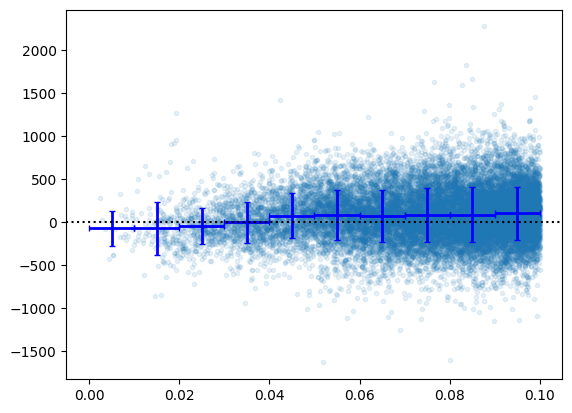

In [304]:
z_max = 0.1
n_bins = 10
width = z_max/n_bins
bounds = np.linspace(0.00, z_max-width, n_bins)
pv = (dset.targets.data.z - dset.targets.data.z_cosmo)*1e-3*c/(1+dset.targets.data.z_cosmo)
in_bins = [(dset.targets.data.z > z_min) & (dset.targets.data.z < z_min + width) for z_min in bounds]
plt.scatter(dset.targets.data.z,
            pv,
            marker=".",
            alpha=0.1,
           )


plt.errorbar(bounds + width/2,
             [pv[filt].mean() for filt in in_bins],
             yerr=[pv[filt].std() for filt in in_bins],
             xerr=width/2,
             linestyle='',
             color='blue',
             linewidth=2,
             alpha=1,
             capsize=2)
plt.axhline(0, color="k", linestyle=":")

In [305]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

### HSC/SNLS

In [69]:
source = sncosmo.get_source('salt2', version='2.4')

model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])

In [71]:
class SNeIa( skysurvey.SNeIa ):

    _COSMOLOGY=cosmo
    _TEMPLATE=model
snia = SNeIa()


In [167]:
survey = extract_snls()

In [73]:
from skysurvey.effects.milkyway import mwebv_model
snia.update_model(t0={"func":np.random.uniform,
                      'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}}, 
                  redshift={'func': 'draw_redshift', "kwargs": {'zmin': 0.16, 'zmax': 1.6}, 'as':'z'},
                  **mwebv_model)

In [168]:
snia = SNeIa.from_data(data_snls.drop(columns=['survey', 'sn']).reset_index(drop=True))

In [74]:
_=snia.draw(tstart=survey.date_range[0], tstop=survey.date_range[1],
          skyarea=survey.get_skyarea().buffer(0.01), zmax=1.6, zmin=0.1,
          inplace=True)
float32_cols = list(snia.data.select_dtypes(include='float32'))
snia.data[float32_cols] = snia.data[float32_cols].astype('float64')


In [169]:
dset = skysurvey.DataSet.from_targets_and_survey(snia, survey, discard_bands=True)

float32_cols = list(dset.data.select_dtypes(include='float32'))
dset.data[float32_cols] = dset.data[float32_cols].astype('float64')

2025-08-12 15:10:50 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/skysurvey/dataset.py:681: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()

2025-08-12 15:10:50 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/skysurvey/dataset.py:681: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  this_survey = gsurvey_indexed.get_group(index_).copy()



In [170]:
with open('/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl', 'wb') as file:
    pickle.dump(dset.targets.data, file)
    pickle.dump(dset.data, file)

### Spectra

In [ ]:
data, lc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')

In [ ]:
lc = lc[(lc.mjd.between(data.loc[lc.sn, 't0'] - 20, data.loc[lc.sn, 't0'] + 50))].copy()
lc['valid'] = (lc.flux/lc.fluxerr>5)

In [382]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc[lc.valid].groupby(["sn"]).band.nunique() >= 2) & \
           (lc[lc.valid].groupby(["sn"])['flux'].count() >= 5) & \
           (lc[lc.valid][lc[lc.valid].mjd < data.loc[lc[lc.valid].sn, "t0"]].groupby("sn").flux.count() >= 2) & \
           (lc[lc.valid][lc[lc.valid].mjd > data.loc[lc[lc.valid].sn, "t0"]].groupby("sn").flux.count() >= 2)

In [383]:
lc = lc[lc.sn.isin(goods_sn[goods_sn].index)]

data = data[data.sn.isin(lc.sn.unique())]

In [384]:
snia = skysurvey.SNeIa.from_data(data)
snia.update_model(#t0={"func":np.random.uniform, 'kwargs':{'low':survey.date_range[0], 'high':survey.date_range[1]}},
                  redshift={"kwargs": {'zmax':1.6,}, 'as':'z'},
                  mwebv={"func": skysurvey.effects.milkyway.get_mwebv, "kwargs": {"ra": "@ra", "dec": "@dec"}},)

source = sncosmo.get_source('salt2', version='2.4')
model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])

snia.set_template(model)

In [385]:
output = lc.loc[data.index].join(data.drop(columns=["sn", "survey"])).drop(columns=['template'])
output['snid'] = output.index

In [386]:
output.rename(columns=dict(mjd="time"), inplace=True)

In [387]:
from mocksurvey.simulations import (
    get_luminosity_distance,
    get_effective_wavelength,
    get_snr,
    build_band_index,
    discard_small_snr,
    discard_skysurvey_flux,
    eliminate_points_not_in_model,
    get_trueflux_and_amplitude,
    get_sn_position,
)

output = get_luminosity_distance(output, snia)
output = get_effective_wavelength(output)

output = eliminate_points_not_in_model(output, snia)
output.to_csv("./outdir/mock_survey.csv", index=False)

2025-07-07 18:24:03 INFO root - Getting luminosity distances in Mpc
2025-07-07 18:24:03 INFO root - Getting effective wavelengths
2025-07-07 18:24:03 INFO root - Eliminating points not in model


In [388]:
output = get_trueflux_and_amplitude(output, snia)

2025-07-07 18:24:19 INFO root - Getting true fluxes and amplitudes


In [389]:
output = get_snr(output)

2025-07-07 18:41:37 INFO root - Getting snr


In [390]:
output = discard_small_snr(output, threshold=0)

2025-07-07 18:41:39 INFO root - Discarding small snr
2025-07-07 18:41:40 INFO root - Getting SN indexes


In [391]:
output = discard_skysurvey_flux(output)

2025-07-07 18:41:41 INFO root - Discarding skysurvey flux


In [392]:
output = get_sn_position(output)

2025-07-07 18:41:41 INFO root - Adding (x, y) positions of the SN


In [393]:
output.to_csv("./outdir/mock_survey.csv", index=False)

In [394]:
output=pandas.read_csv('./outdir/mock_survey.csv')

In [395]:
def f(x, a, b, c):
    """ """
    return a * x**2 + b * x + c
data_sim = []

idx = output["fluxtrue"] != 0
output = output[idx]

mock_snid = np.unique(output["snid"])

length_wave = np.array([218, 437, 3258, 656, 868])
popt = np.array([-7.87649259e-07, 1.08382223e-02, -2.44390307e01])
a, b, c = popt

In [396]:
for i,snid in tqdm(enumerate(mock_snid), total=len(mock_snid)):
    try:
        mock_sn = output[output["snid"] == snid]
        x0 = mock_sn.iloc[0]["x0"]
        x1 = mock_sn.iloc[0]["x1"]
        c = mock_sn.iloc[0]["c"]
        t0 = mock_sn.iloc[0]["t0"]
        z = mock_sn.iloc[0]["z"]
        mwebv = mock_sn.iloc[0]["mwebv"]
        
        wave_size = np.random.choice(length_wave)
        min_wave = np.random.uniform(2900.0, 3400.0)
        max_wave = np.random.uniform(9000.0, 11000.0)
        wavelength = np.linspace(min_wave, max_wave, wave_size)
        
        
        mjd = np.random.choice(mock_sn["time"][mock_sn["time"].between(t0 - 10, t0 + 40)])
        
        source = sncosmo.get_source('salt2', version='2.4')
        model= sncosmo.Model(source=source,effects=[sncosmo.CCM89Dust()],effect_names=['mw'],effect_frames=['obs'])
        p = {"z": z, "t0": t0, "x0": x0, "x1": x1, "c": c, "mwebv": mwebv, "mwr_v": 3.1}
        model.set(**p)
        
        min_w = model.minwave()
        max_w = model.maxwave()
        
        try:
            flux_true = model.flux(mjd, wavelength)
        except:
            try:
                wavelength = wavelength[wavelength < model.maxwave()]
                flux_true = model.flux(mjd, wavelength)
            except:
                wavelength = wavelength[wavelength > model.minwave()]
                flux_true = model.flux(mjd, wavelength)
        
        norm_values = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1e12])
        norm = np.random.choice(norm_values)
        flux_true *= norm
        flux_err = (flux_true / f(wavelength, a, b, c)) * np.random.randn(
            len(flux_true)
        )
        flux = flux_true + 0.5 * flux_err
        
        spec_sim = pandas.DataFrame(columns=["spec","time","wavelength","flux","fluxerr","valid","exptime","snid","flux_true","x0","x1","c","t0","mwebv","z"],
                                   dtype=('int','float'))
        spec_sim['wavelength'] = wavelength
        spec_sim['flux'] = flux
        spec_sim['flux_true'] = flux_true
        spec_sim['fluxerr'] = np.abs(flux_err)
        spec_sim['time'] = mjd
        spec_sim['valid'] = 1
        spec_sim['exptime'] = np.nan
        spec_sim['sn'] = mock_sn.iloc[0]["sn"]
        spec_sim['snid'] = snid
        spec_sim['spec'] = i
        spec_sim["z"] = z
        spec_sim["x0"] = x0
        spec_sim["x1"] = x1
        spec_sim["c"] = c
        spec_sim["t0"] = t0
        spec_sim["mwebv"] = mwebv
        data_sim.append(spec_sim)
    except ValueError as e:
        logging.info(f"No spectra could be generated for the sn {mock_sn.iloc[0]['sn']}")
        continue
spec = pandas.concat(data_sim)

  0%|          | 0/7075 [00:00<?, ?it/s]

In [397]:
spec.to_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv", index=False)

### TDS

In [234]:
data_ztf, lc_ztf = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_2M++.pkl", survey='ZTF')
data_hsc, lc_hsc = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_hsc.pkl", survey='HSC')
data_snls, lc_snls = load_from_skysurvey("/cfs/data/angi0819/Projet_LPNHE/dataset_snls.pkl", survey='SNLS')

In [235]:
spec_ztf = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_2M++.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_ztf['survey'] = 'ZTF'
spec_hsc = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_hsc.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_hsc['survey'] = 'HSC'
spec_snls = pandas.read_csv("/cfs/data/angi0819/Projet_LPNHE/spectra_snls.csv").drop(columns=['x0','x1','c','t0','mwebv','z','flux_true','snid'])
spec_snls['survey'] = 'SNLS'
shift_sp_ztf, shift_sp_snls = spec_ztf.spec.max()+1, spec_snls.spec.max()+1
spec_snls.spec += shift_sp_ztf
spec_hsc.spec += shift_sp_ztf + shift_sp_snls

In [236]:
data = pandas.concat([data_ztf, data_snls, data_hsc])
lc = pandas.concat([lc_ztf, lc_snls, lc_hsc])
spec = pandas.concat([spec_ztf, spec_snls, spec_hsc])

In [237]:
# Select only points in [tmax-50, tmax+100]
lc = lc[(lc.mjd.between(data.loc[lc.sn, 't0'] - 50,
                                     data.loc[lc.sn, 't0'] + 100))].copy()

# Select SN on : >=5 detections in >=2 bands
goods_sn = (lc.groupby(["sn"]).band.nunique() >= 2) & \
           (lc.groupby(["sn"])['flux'].count() >= 5) & \
           (lc[lc.mjd < data.loc[lc.sn, "t0"]].groupby("sn").flux.count() >= 2) & \
           (lc[lc.mjd > data.loc[lc.sn, "t0"]].groupby("sn").flux.count() >= 2)


In [238]:
lc = lc[goods_sn.loc[lc.sn]]
data = data[data.sn.isin(lc.sn.unique())]
spec = spec[spec.sn.isin(lc.sn.unique())]

In [239]:
extra_cols = ['zp']
lc['flux_ab'] = lc.flux * np.power(10, -0.4*lc.zp)
lc['fluxerr_ab'] = lc.fluxerr * np.power(10, -0.4*lc.zp)
from lccalib.averaging import night_averager, add_columns

cat, idx, goods = night_averager(lc,
                                 mjd_key='mjd',
                                 flux_key='flux_ab',
                                 eflux_key='fluxerr_ab',
                                 group_by=['sn', 'band'])

In [240]:
cat = add_columns(cat, lc, extra_cols, idx, goods)

In [241]:
lcs = pandas.DataFrame(cat).copy()
lcs['flux'] *= np.power(10, 0.4 * lcs['zp'])
lcs['eflux'] *= np.power(10, 0.4 * lcs['zp'])
lcs['rms'] *= np.power(10., 0.4 * lcs['zp'])
lcs = lcs.rename(columns={"eflux":"fluxerr"})
lcs['lc'] = ''
lcs['lc'].values[idx] = lc.sn.values[goods] + '_' + lc.band.values[goods]
lcs['zpsys'] = ''
lcs['zpsys'].values[idx] = lc.zpsys.values[goods]
lcs['sn'] = lc.sn.iloc[0]
lcs['sn'].values[idx] = lc.sn.values[goods]
lcs['band'] = ''
lcs['band'].values[idx] = lc.band.values[goods]


In [242]:
lcs.set_index('sn', drop=False, inplace=True)
lcs.index.name = None

In [243]:
lcs['phase'] = (lcs.mjd - data.loc[lcs.sn, 't0'])/(1+data.loc[lcs.sn, 'z'])

In [244]:
lcs = lcs[lcs.phase.between(-15, 45)].copy()

In [245]:
z_cuts = pandas.DataFrame([0.01, 0.1, 0.1], index=['ZTF', 'HSC', 'SNLS'], columns=['cut'])
too_low_z = data.loc[data.z.values < z_cuts.loc[data.survey, 'cut'].values, 'sn'].values

In [246]:
# Select SN on : >=5 detections in >=2 bands
goods_sn = (lcs.groupby(["sn"]).band.nunique() >= 2) & \
           (lcs.groupby(["sn"])['flux'].count() >= 5) & \
           (lcs[lcs.mjd < data.loc[lcs.sn, "t0"]].groupby("sn").flux.count() >= 2) & \
           (lcs[lcs.mjd > data.loc[lcs.sn, "t0"]].groupby("sn").flux.count() >= 2)
goods_sn.loc[too_low_z] = False

In [247]:
lcs = lcs[goods_sn.loc[lcs.sn]]
lcs = lcs.drop(columns=['phase']).reset_index(drop=True)
data = data[data.sn.isin(lcs.sn.unique())]
spec = spec[spec.sn.isin(lcs.sn.unique())]

In [248]:
lc_dtype=np.dtype([
    ('sn', 'O'), ('mjd', '<f8'), ('flux', '<f8'), ('fluxerr', '<f8'),
    ('band', 'O'), ('magsys', 'O'), ('exptime', '<f8'), ('valid', '<i8'),
    ('lc', 'O'), ('zp', '<f8'), ('mag_sky', '<f8'), ('seeing', '<f8'),
    ('x', '<f8'),('y', '<f8'), ('sensor_id', '<i8')])

N = len(lcs)
lc_rec = np.recarray((N), dtype=lc_dtype)
lc_rec["sn"] = lcs.sn
lc_rec["mjd"] = lcs.mjd
lc_rec["flux"] = lcs.flux
lc_rec["fluxerr"] = lcs.fluxerr
lc_rec["band"] = lcs.band
lc_rec["zp"] = lcs.zp
lc_rec["magsys"] = lcs.zpsys
lc_rec["valid"] = np.ones(N)
lc_rec["lc"] = lcs.lc

In [249]:
sn_dtype=np.dtype([
    ('sn', 'O'), ('z', '<f8'), ('tmax', '<f8'), ('x1', '<f8'),
    ('x0', '<f8'), ('c', '<f8'), ('mwebv', '<f8'), ('valid', '<i8'), ('IAU', 'O'), ('survey', 'O')])

N = len(data)
sn_rec = np.recarray((N), dtype=sn_dtype)
sn_rec["sn"] = data.sn
sn_rec["z"] = data.z
sn_rec["x0"] = data.x0
sn_rec["x1"] = data.x1
sn_rec["c"] = data.c
sn_rec["tmax"] = data.t0
sn_rec["mwebv"] = data.mwebv
sn_rec["valid"] = np.ones(N)
sn_rec["survey"] = data.survey


In [250]:
sp_dtype = np.dtype([
        ('sn', 'O'),
        ('mjd', '<f8'),
        ('wavelength', '<f8'),
        ('flux', '<f8'),
        ('fluxerr', '<f8'),
        ('i_basis', '<i8'),
        ('valid', '<i8'),
        ('spec', '<i8'),
        ('exptime', '<f8'),])
N = len(spec)
spec_rec = np.recarray((N), dtype=sp_dtype)

spec_rec['sn'] = spec.sn
spec_rec['mjd'] = spec.time
spec_rec['wavelength'] = spec.wavelength
spec_rec['flux'] = spec.flux
spec_rec['fluxerr'] = spec.fluxerr
spec_rec['i_basis'] = np.zeros(N)
spec_rec['valid'] = spec.valid
spec_rec['spec'] = spec.spec
spec_rec['exptime'] = spec.exptime

In [251]:
tds = TrainingDataset(sn_rec, lc_data=lc_rec,
                      spec_data=spec_rec,
                      filterlib=filterlib)

2025-08-14 15:59:27 WARNING root - bandpass MEGACAM6::g not in filterlib -- retrieving it from sncosmo
2025-08-14 15:59:27 WARNING root - bandpass MEGACAM6::i not in filterlib -- retrieving it from sncosmo
2025-08-14 15:59:27 WARNING root - bandpass MEGACAM6::i2 not in filterlib -- retrieving it from sncosmo
2025-08-14 15:59:27 WARNING root - bandpass MEGACAM6::r not in filterlib -- retrieving it from sncosmo
2025-08-14 15:59:27 WARNING root - bandpass MEGACAM6::z not in filterlib -- retrieving it from sncosmo
2025-08-14 15:59:27 WARNING root - bandpass ztf::i not in filterlib -- retrieving it from sncosmo


In [ ]:
tds.to_parquet('tds_full', path='/cfs/data/angi0819/Projet_LPNHE/')


### lc fit

In [365]:
source = sncosmo.get_source('salt2', version='2.4')

model = sncosmo.Model(source=source, effects=[sncosmo.CCM89Dust()], effect_names=['mw'], effect_frames=['obs'])

In [378]:
tds = TrainingDataset.read_parquet("tds", path='/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/',
                                   filterlib=filterlib)

2025-08-14 16:50:34 WARNING root - bandpass MEGACAM6::g not in filterlib -- retrieving it from sncosmo
2025-08-14 16:50:34 WARNING root - bandpass MEGACAM6::i not in filterlib -- retrieving it from sncosmo
2025-08-14 16:50:34 WARNING root - bandpass MEGACAM6::i2 not in filterlib -- retrieving it from sncosmo
2025-08-14 16:50:34 WARNING root - bandpass MEGACAM6::r not in filterlib -- retrieving it from sncosmo
2025-08-14 16:50:34 WARNING root - bandpass MEGACAM6::z not in filterlib -- retrieving it from sncosmo
2025-08-14 16:50:34 WARNING root - bandpass ztf::i not in filterlib -- retrieving it from sncosmo


In [379]:
sn_data = pandas.DataFrame(tds.sn_data.nt).set_index('sn', drop=False)
sn_data.index.name=None

In [380]:
lc_data = pandas.DataFrame(tds.lc_data.nt).set_index('sn', drop=False).rename(columns=dict(mjd="time", magsys='zpsys'))

In [381]:
lc_data = lc_data.loc[(lc_data.flux/lc_data.fluxerr > 5), ['time', 'band', 'flux', 'fluxerr', 'zp', 'zpsys', 'sn', 'lc']].copy()

In [382]:
import copy
def res_to_table(res, sn):
    try:
        fitted_values = {**{k:v for k, v in zip(res.param_names, res.parameters) if k in res.vparam_names},
                         **{k+"_err":v for k, v in res.errors.items()},}
    
        for i in range(len(res.vparam_names)):
            for j in range(i, len(res.vparam_names)):
                fitted_values["cov_" + res.vparam_names[i]+"_"+res.vparam_names[j]]=res.covariance[i,j]
    
        for k in ['success', 'ncall', 'chisq', 'ndof']:
            fitted_values[k] = res[k]
        return pandas.DataFrame(fitted_values, index=[sn])
    except TypeError as e:
        return res, sn

def fit_sn(sn, lc_data,
           z, mwebv,
           model,
           modelcov=True,
           bounds={"x0":[-1., 10.],
                   "x1":[-4., 4.],
                   "c": [-0.4, 1.2]},
           vparam_names=["x0", "x1", "c", "t0"]):
    _model = copy.copy(model)
    _model.set(z=z, mwebv=mwebv)
    res, fitted_model = sncosmo.fit_lc(lc_data, _model,
                                       vparam_names=vparam_names,
                                       bounds=bounds,
                                       modelcov=modelcov,
                                       phase_range=[-10, 40])
    df = res_to_table(res, sn)
    df['z'] = z
    df['mwebv'] = mwebv
    return df

In [383]:
from astropy.table import Table

def fit_all(sn_data, lc_data, client=None, **kwargs):
    if client is None:
        results = [fit_sn(sn, Table.from_pandas(lc_data.loc[sn]), sn_data.loc[sn,'z'], sn_data.loc[sn,'mwebv'], model, **kwargs) for sn in tqdm(lc_data.index.unique())]
        return pandas.concat(results)
    else:
        future_results = [delayed(fit_sn)(sn, Table.from_pandas(lc_data.loc[sn]), sn_data.loc[sn,'z'], sn_data.loc[sn,'mwebv'], model, **kwargs)
                            for sn in lc_data.index.unique()]
        return future_results

In [389]:
sn = 'ZTF_3'

In [390]:
_data = Table.from_pandas(lc_data.loc[sn])
_z = sn_data.loc[sn, 'z']
_x0 = sn_data.loc[sn, 'x0']
_x1 = sn_data.loc[sn, 'x1']
_c = sn_data.loc[sn, 'c']
_mwebv = sn_data.loc[sn, 'mwebv']
_t0 = sn_data.loc[sn, 'tmax']

In [391]:
sn_data.loc[sn]

index                1
sn               ZTF_3
z             0.096618
tmax      58485.515625
x1               0.185
x0            0.000292
c                0.091
mwebv         0.026178
valid                1
IAU               None
survey             ZTF
Name: ZTF_3, dtype: object

In [392]:
_z, _mwebv, _t0

(0.09661824256181717, 0.026178153231739998, 58485.515625)

In [393]:
model_sn = copy.copy(model)
model_sn.set(z=_z, mwebv=_mwebv, t0=_t0, x0=_x0, x1=_x1, c=_c)

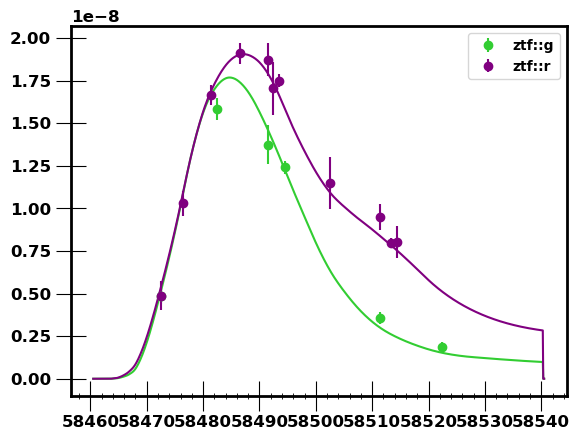

In [394]:
coeff = np.power(10,-0.4*_data["zp"])

for b in np.unique(_data['band']):
    filt = (_data['band']==b)
    plt.errorbar(_data['time'][filt],
                 _data['flux'][filt] * coeff[filt],
                 _data['fluxerr'][filt] * coeff[filt],
                 c = color_band[b.lower()],
                 linestyle='', marker='o', label=b)
    
    plt.plot(np.linspace(_t0 - 25, _t0 + 55, 1000),
             model_sn.bandflux(np.array([b]*1000), np.linspace(_t0 - 25, _t0 + 55, 1000), zp=0, zpsys='ab'),
             c = color_band[b.lower()],)
    
plt.legend()

In [395]:
res_sn, fitted_model = sncosmo.fit_lc(_data, model_sn,
                               vparam_names=["x0", "x1", "c", "t0"],
                               bounds={"x0":[-1., 10.],
                                       "x1":[-4., 4.],
                                       "c": [-0.4, 1.2],
                                       "t0": [_t0 - 10, _t0 + 10]
                                      },
                                modelcov=True,
                                phase_range=[-10, 40],
                                verbose=True,
                               )
res_to_table(res_sn, sn)

Initial parameters:
t0 58485.18184188381 step= 0.4 bounds= [58475.515625, 58495.515625] 
x0 0.0002928496134849043 step= 0.22 bounds= [-1.0, 10.0] 
x1 0.1850000023841858 step= 0.16 bounds= [-4.0, 4.0] 
c 0.09099999815225601 step= 0.032 bounds= [-0.4, 1.2] 

104 function calls; 13 dof.
Initial parameters:
t0 58486.17782205795 step= 0.4 bounds= [58475.515625, 58495.515625] 
x0 0.00027602752692772387 step= 0.22 bounds= [-1.0, 10.0] 
x1 0.5662783592132806 step= 0.16 bounds= [-4.0, 4.0] 
c 0.14310516327431072 step= 0.032 bounds= [-0.4, 1.2] 

93 function calls; 11 dof.
Initial parameters:
t0 58486.31211355268 step= 0.4 bounds= [58475.515625, 58495.515625] 
x0 0.0002743714849254657 step= 0.22 bounds= [-1.0, 10.0] 
x1 0.5263835405761591 step= 0.16 bounds= [-4.0, 4.0] 
c 0.14979285690812577 step= 0.032 bounds= [-0.4, 1.2] 

54 function calls; 11 dof.


,t0,x0,x1,c,t0_err,x0_err,x1_err,c_err,cov_t0_t0,cov_t0_x0,...,cov_x0_x0,cov_x0_x1,cov_x0_c,cov_x1_x1,cov_x1_c,cov_c_c,success,ncall,chisq,ndof
ZTF_3,58486.312694,0.000274,0.528214,0.149855,0.296778,0.000012,0.341893,0.038926,0.088103,-7.284433e-07,...,1.369435e-10,-0.000001,-3.884602e-07,0.117182,0.001577,0.001517,True,54,4.494535,11


In [396]:
import copy
true_model = copy.copy(model_sn)
true_model.set(**{k if k!='tmax' else 't0':sn_data.loc[sn, k] for k in ['tmax', 'x0', 'x1', 'c']})

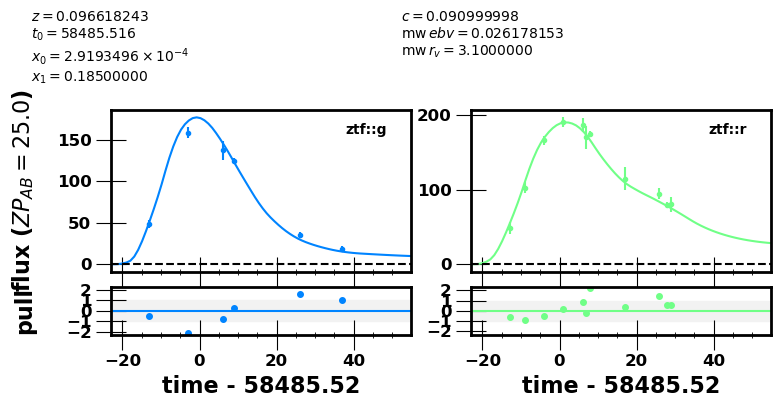

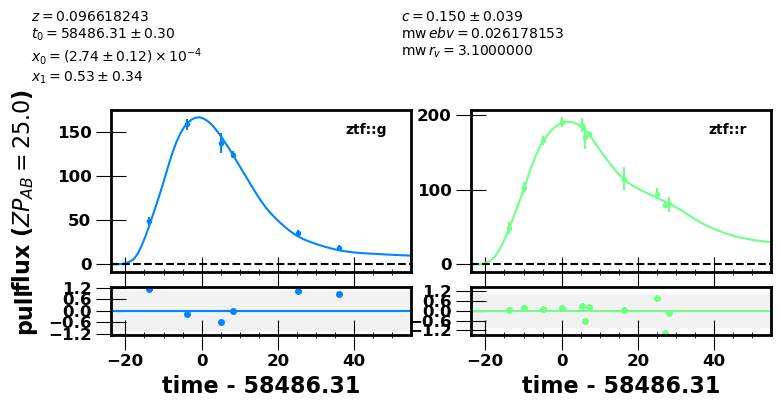

In [397]:
_=sncosmo.plot_lc(_data, true_model)
_=sncosmo.plot_lc(_data, fitted_model, errors=res_sn.errors)

In [398]:
from dask.distributed import Client, get_client
from dask.delayed import delayed
from dask.distributed import progress

try:
    client.close()
except:
    pass
finally:
    Client(n_workers=16, threads_per_worker=4)
    client=get_client()

2025-08-14 16:51:13 INFO distributed.nanny - Closing Nanny at 'tcp://127.0.0.1:38588'. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Nanny asking worker to close. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Closing Nanny at 'tcp://127.0.0.1:43898'. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Nanny asking worker to close. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Closing Nanny at 'tcp://127.0.0.1:41648'. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Nanny asking worker to close. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Closing Nanny at 'tcp://127.0.0.1:34295'. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Nanny asking worker to close. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Closing Nanny at 'tcp://127.0.0.1:38301'. Reason: nanny-close
2025-08-14 16:51:13 INFO distributed.nanny - Nanny asking worker to close. Reason: na

In [399]:
goods_sn = (lc_data.drop(columns="sn").groupby(["sn"]).band.nunique() >= 2) & \
           (lc_data.drop(columns="sn").groupby(["sn"])['flux'].count() >= 5) & \
           (lc_data[lc_data.time < sn_data.loc[lc_data.sn, "tmax"]].drop(columns="sn").groupby("sn").flux.count() >= 2) & \
           (lc_data[lc_data.time > sn_data.loc[lc_data.sn, "tmax"]].drop(columns="sn").groupby("sn").flux.count() >= 2)
lc_data = lc_data[lc_data.sn.isin(goods_sn[goods_sn].index)]

In [400]:
submit_results = [delayed(fit_sn)(sn, Table.from_pandas(lc_data.loc[sn]),
                                  sn_data.loc[sn,'z'],
                                  sn_data.loc[sn,'mwebv'],
                                  model,
                                  modelcov=True)
                    for sn in tqdm(lc_data.index.unique(), desc='Creating delayed objects')]

Creating delayed objects:   0%|          | 0/6309 [00:00<?, ?it/s]

In [401]:
futures_results = client.compute(submit_results)
progress(futures_results)

2025-08-14 16:51:39 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 39.77 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



VBox()

In [402]:
res_ = client.gather(futures_results, errors='skip')

In [403]:
res = pandas.concat(res_)

In [404]:
res["survey"] = list(map(lambda x: x.split("_")[0], np.array(res.index)))

In [405]:
def build_cov_from_df(res):
    cov = np.zeros((3,3, len(res)))
    for i, k1 in enumerate(['x0', 'x1', 'c']):
        for j, k2 in enumerate(['x0', 'x1', 'c']):
            if i <= j:
                cov[i,j,...] = cov[j,i,...] = res['cov_' + k1 + '_' + k2]
    return cov.T

In [406]:
covs = build_cov_from_df(res)

In [407]:
test = (np.identity(3)[..., None] @ np.ones(len(res))[None, None,...])
test[0, 0] =  -2.5 / (np.log(10) * res["x0"].values)
test=test.T

In [408]:
new_covs=np.matmul(test, np.matmul(covs, test))

In [409]:
res['Mb_err']=np.sqrt(new_covs[...,0,0])
res['Mb'] = -2.5*np.log10(res['x0'])

In [410]:
res['mu'] = res.Mb + 0.14*res.x1 - 3.15*res.c
to_mu = (np.array([[1, 0.14, -3.15]])[..., None] @ np.ones(len(res))[None, None,...]).T

In [411]:
res['mu_err'] = np.sqrt(np.matmul(to_mu.transpose((0, 2, 1)), np.matmul(new_covs, to_mu)).reshape(-1))

In [412]:
res['t0_true'] = sn_data.tmax
res['x0_true'] = sn_data.x0
res['x1_true'] = sn_data.x1
res['c_true'] = sn_data.c

In [413]:
bounds={"x0":np.array([-1., 10.]),
       "x1":np.array([-4., 4.]),
       "c": np.array([-0.4, 1.2])}

In [414]:
res.to_pickle('/cfs/data/angi0819/Projet_LPNHE/salt_fit_modelcov.pkl')

In [415]:
stuck_x1 = np.any(np.abs(bounds["x1"][None,...] - res.x1.values[...,None]) < 0.01*np.diff(bounds["x1"]), axis=1)
stuck_c  = np.any(np.abs(bounds["c"][None,...]  - res.c.values[...,None])  < 0.01*np.diff(bounds["c"]),  axis=1)
stuck_x0 = np.any(np.abs(bounds["x0"][None,...] - res.x0.values[...,None]) < 0.01*np.diff(bounds["x0"]), axis=1)
not_stuck =  ~(stuck_x1 | stuck_c | stuck_x0)

chi2_cut = (res.chisq/res.ndof < 3) & (res.ndof > 0)
x1_cut = res.x1.between(-3, 3)
c_cut = res.c.between(-0.2, 0.8)
sigma_t0 = (res.t0_err < 1)
sigma_x1 = (res.x1_err < 1)
sigma_c = (res.c_err < 1)

In [416]:
total_cut = res.t0 > 0
print(f"\t\tSNe kept\tCut")
print(f"Total\t\t{total_cut.sum()}\t\t-")

for cut in ["not_stuck", "chi2_cut", "x1_cut", "c_cut", "sigma_t0", "sigma_x1", "sigma_c"]:
    print(cut+f"   \t{(total_cut & eval(cut)).sum()}\t\t{total_cut.sum()-(total_cut & eval(cut)).sum()}")
    total_cut &= eval(cut)
print("-"*36)
print(f"Total\t\t{total_cut.sum()}\t\t{(~total_cut).sum()}")
res.loc[~total_cut, "success"] = False    

		SNe kept	Cut
Total		6309		-
not_stuck   	6272		37
chi2_cut   	6244		28
x1_cut   	6209		35
c_cut   	6195		14
sigma_t0   	5759		436
sigma_x1   	5560		199
sigma_c   	5560		0
------------------------------------
Total		5560		749


In [417]:
print('\tTotal\tGoods')
for s in res.survey.unique():
    print(s +f"\t{(res.survey==s).sum()}\t{(res.success & (res.survey==s)).sum()}")

	Total	Goods
HSC	137	35
SNLS	643	317
ZTF	5529	5208


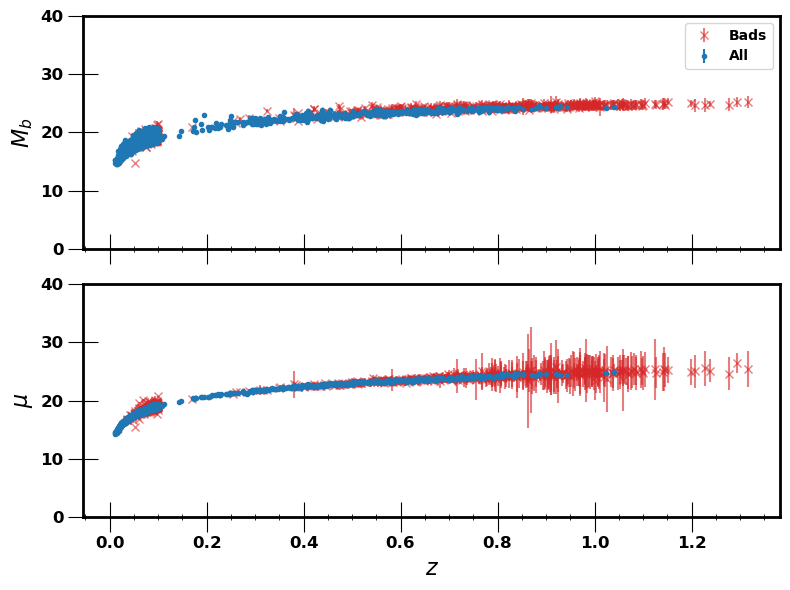

In [418]:
fig, (axmb, axmu) = plt.subplots(nrows=2, sharex=True, figsize=(8,6))
axmb.errorbar(res[~res.success].z,
              res[~res.success].Mb + model.bandmag('bessellb', 'ab', 0.),
              res[~res.success].Mb_err,
              alpha=0.6,
              marker='x',
              linestyle='',
              color='tab:red', label='Bads')
axmb.errorbar(res.z[res.success],
             res.Mb[res.success] + model.bandmag('bessellb', 'ab', 0.),
             res.Mb_err[res.success],
             marker='.',
             linestyle='', label='All')
axmb.legend()
axmb.set_ylim(0, 40)
axmb.set_ylabel("$M_b$")
axmu.errorbar(res[~res.success].z,
             res[~res.success].mu + model.bandmag('bessellb', 'ab', 0.),
             res[~res.success].mu_err,
             alpha=0.6,
             marker='x',
             linestyle='',
             color='tab:red', )
axmu.errorbar(res.z[res.success],
             res.mu[res.success] + model.bandmag('bessellb', 'ab', 0.),
             res.mu_err[res.success],
             marker='.',
             linestyle='', label=r'$\mu$')
axmu.set_ylim(0, 40)

axmu.set_xlabel("$z$")
axmu.set_ylabel(r"$\mu$")
fig.tight_layout()

2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol . from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol 5 from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol ) from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-08-14 17:04:06 INFO matplotlib.mathtext - S

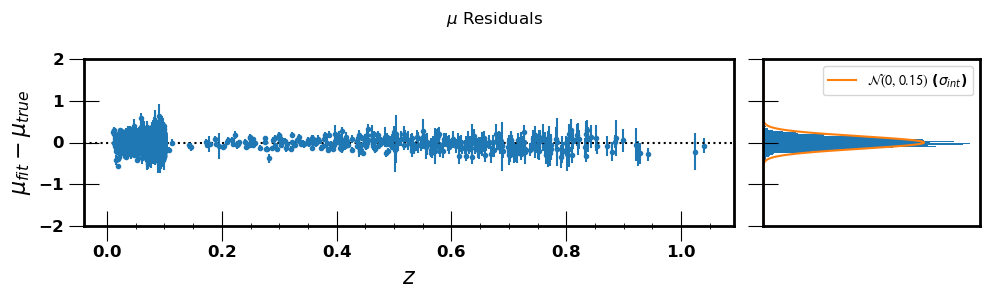

In [419]:
fig, axs = plt.subplots(figsize=(10, 3), width_ratios=[3, 1], ncols=2, sharey='row')
goods = res[res.success]
axs[0].errorbar(goods.z,
             goods.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - cosmo.distmod(goods.z).value,
             goods.mu_err,
            marker='.',
            linestyle='')
axs[0].axhline(0, linestyle=':', color='k')
axs[1].hist((goods.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(goods.z).value),
            orientation='horizontal',
            density=True,
            bins=100,)

axs[1].plot(1/np.sqrt(2*np.pi)/0.15*np.exp(-(np.linspace(-2, 2, 1000)/0.15)**2/2), np.linspace(-2, 2, 1000), label=r'$\mathcal{N(0, 0.15)}$ ($\sigma_{int}$)')
axs[1].legend()

axs[0].set_ylim(-2, 2)
axs[0].set_ylabel(r'$\mu_{fit} - \mu_{true}$')
axs[0].set_xlabel(r'$z$')
axs[1].set_xticks([])
fig.suptitle(r"$\mu$ Residuals")
fig.tight_layout()

2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol ) from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol N from STIXNonUnicode
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol ( from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol 0 from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol , from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - Substituting symbol 1 from STIXGeneral
2025-08-14 17:04:07 INFO matplotlib.mathtext - S

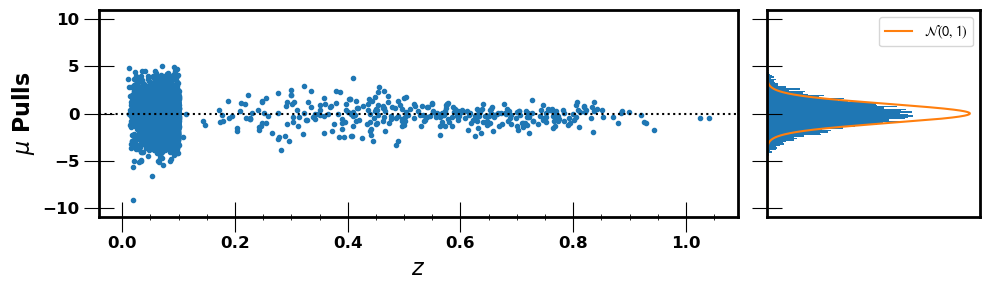

In [420]:
fig, axs = plt.subplots(figsize=(10, 3), width_ratios=[3, 1], ncols=2, sharey='row')
axs[0].scatter(goods.z,
         (goods.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(goods.z).value)/goods.mu_err,
        marker='.')
axs[0].axhline(0, linestyle=':', color='k')
axs[1].hist((goods.mu + model.bandmag('bessellb', 'ab', 0.) + 19.3 - \
          cosmo.distmod(goods.z).value)/goods.mu_err,
            orientation='horizontal',
            density=True,
            bins=100,)
axs[1].plot(1/np.sqrt(2*np.pi)*np.exp(-np.linspace(-10, 10, 1000)**2/2), np.linspace(-10, 10, 1000), label=r'$\mathcal{N(0, 1)}$')
axs[1].legend()
# axs[0].set_ylim(-10, 10)
axs[0].set_ylabel(r'$\mu$ Pulls')
axs[0].set_xlabel(r'$z$')
axs[1].set_xticks([])
fig.tight_layout()

Text(0, 0.5, 'Residuals $t_{max}^{fit} - t_{max}^{true}$')

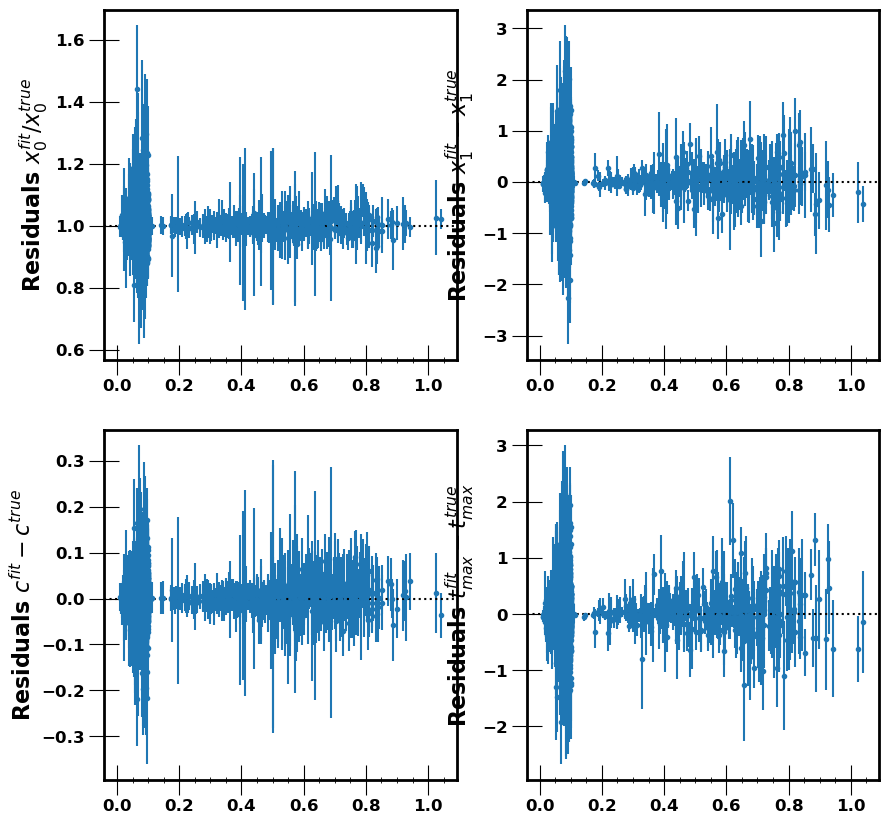

In [421]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sty = dict(marker='.', linestyle='', )
axs[0, 0].errorbar(res.z[res.success],
                   res.x0[res.success]/res.x0_true[res.success],
                   res.x0_err[res.success]/res.x0_true[res.success],
                   **sty)
# axs[0, 0].set_yscale("symlog", linthresh=1e-8)
axs[0, 0].axhline(1, color='k', linestyle=':')

axs[0, 1].errorbar(res.z[res.success],
                   res.x1[res.success]-res.x1_true[res.success],
                   res.x1_err[res.success],
                   **sty)
axs[0, 1].axhline(0, color='k', linestyle=':')

axs[1, 0].errorbar(res.z[res.success],
                   res.c[res.success]-res.c_true[res.success],
                   res.c_err[res.success],
                   **sty)
axs[1, 0].axhline(0, color='k', linestyle=':')

axs[1, 1].errorbar(res.z[res.success],
                   res.t0[res.success]-res.t0_true[res.success],
                   res.t0_err[res.success],
                   **sty)
axs[1, 1].axhline(0, color='k', linestyle=':')

axs[0, 0].set_ylabel(r'Residuals $x_0^{fit} / x_0^{true}$')
axs[1, 0].set_ylabel(r'Residuals $c^{fit} - c^{true}$')
axs[0, 1].set_ylabel(r'Residuals $x_1^{fit} - x_1^{true}$')
axs[1, 1].set_ylabel(r'Residuals $t_{max}^{fit} - t_{max}^{true}$')


Text(0, 0.5, 'Pulls $t_{max}$')

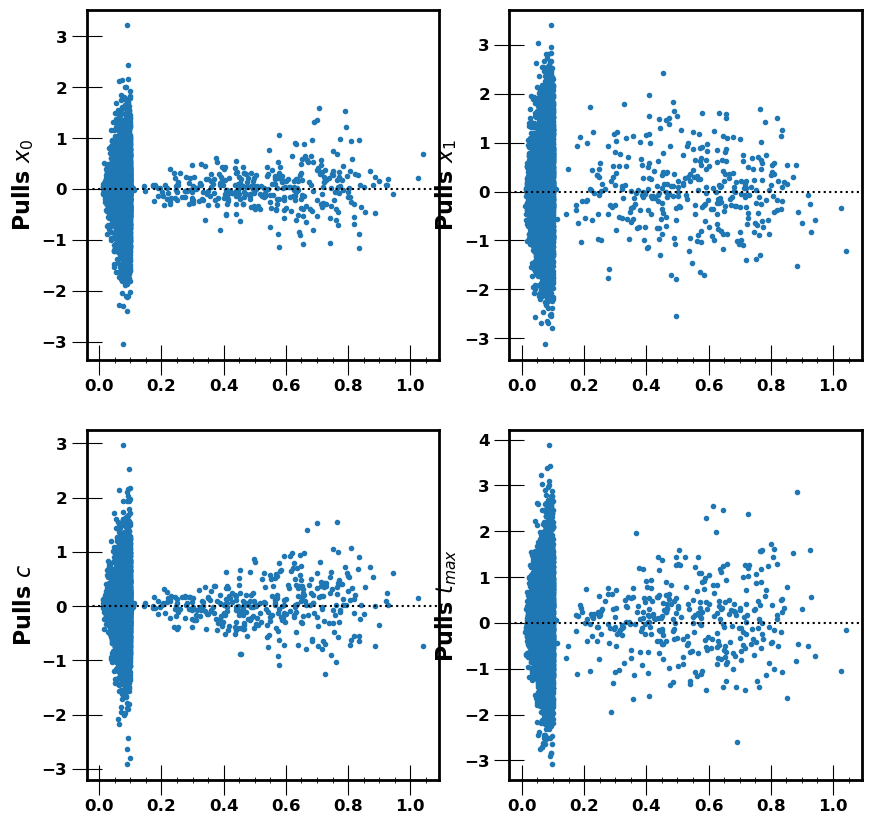

In [422]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sty = dict(marker='.')
axs[0, 0].scatter(res.z[res.success],
                   (res.x0[res.success]-res.x0_true[res.success])/res.x0_err[res.success],
                   **sty)
axs[0, 0].axhline(0, color='k', linestyle=':')

axs[0, 1].scatter(res.z[res.success],
                   (res.x1[res.success]-res.x1_true[res.success])/res.x1_err[res.success],
                   **sty)
axs[0, 1].axhline(0, color='k', linestyle=':')

axs[1, 0].scatter(res.z[res.success],
                   (res.c[res.success]-res.c_true[res.success])/res.c_err[res.success],
                   **sty)
axs[1, 0].axhline(0, color='k', linestyle=':')

axs[1, 1].scatter(res.z[res.success],
                   (res.t0[res.success]-res.t0_true[res.success])/res.t0_err[res.success],
                   **sty)
axs[1, 1].axhline(0, color='k', linestyle=':')

axs[0, 0].set_ylabel(r'Pulls $x_0$')
axs[1, 0].set_ylabel(r'Pulls $c$')
axs[0, 1].set_ylabel(r'Pulls $x_1$')
axs[1, 1].set_ylabel(r'Pulls $t_{max}$')


In [423]:
sn_data_single = sn_data.loc[lc_data.index.unique()[~lc_data.index.unique().isin(res.index)]]
lc_data_single = lc_data.loc[lc_data.index.unique()[~lc_data.index.unique().isin(res.index)]]

submit_bads = fit_all(sn_data_single, lc_data_single, client=client)

In [ ]:
futures_bads = client.compute(submit_bads)

In [ ]:
bads_res = client.gather(futures_bads)

In [556]:
res = pandas.concat([res, *bads_res])

In [424]:
sn_pars = pandas.read_parquet("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars.parquet")

In [425]:
cov = np.load("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars_cov.npy")

In [426]:
errs_ = np.sqrt(np.diag(cov))
sn_pars["x0_err"] = errs_[:len(sn_pars)]
sn_pars["x1_err"] = errs_[len(sn_pars):2*len(sn_pars)]
sn_pars["c_err"] = errs_[2*len(sn_pars):3*len(sn_pars)]
sn_pars["tmax_err"] = errs_[3*len(sn_pars):]


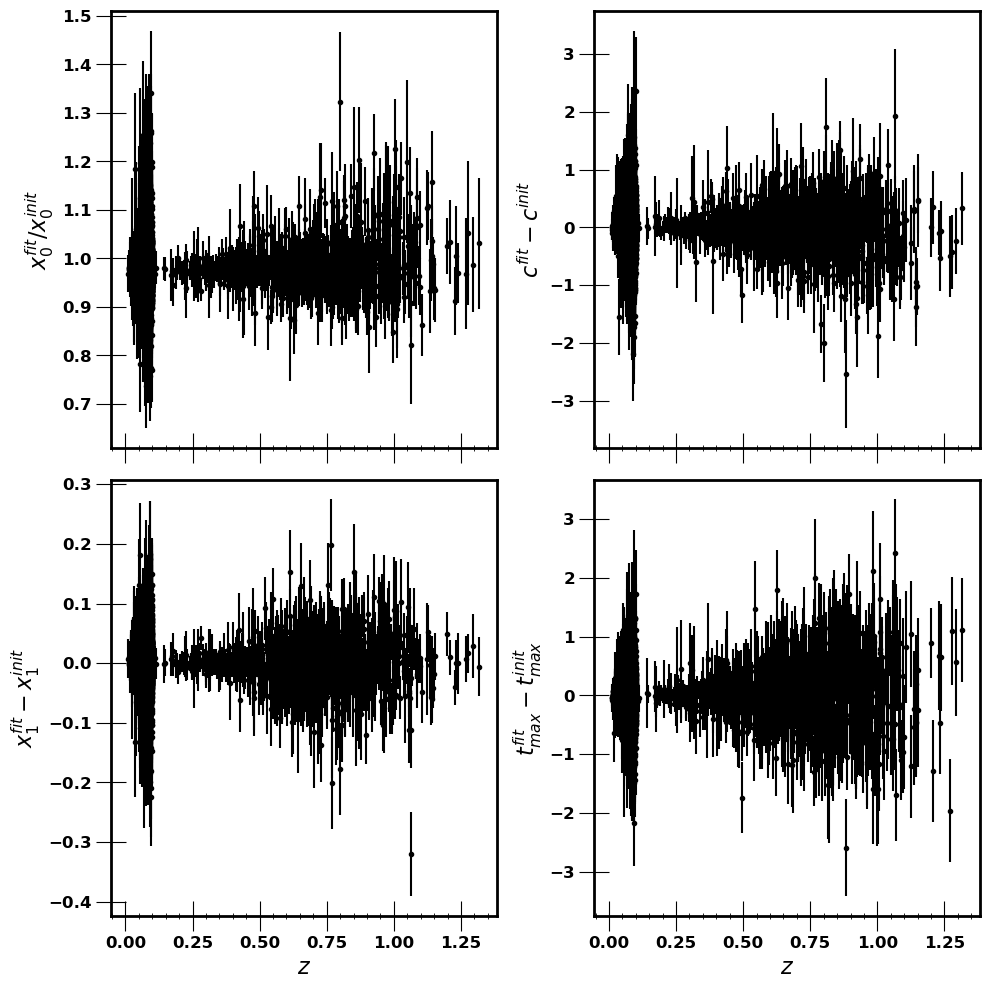

In [427]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10), sharex='all')
sty = dict(marker='.', linestyle='', color='k')
axs[0, 0].errorbar(sn_pars.z,
                   sn_pars.x0/sn_pars.x0_init,
                   sn_pars.x0_err/sn_pars.x0_init,
                   **sty)
axs[0, 1].errorbar(sn_pars.z,
                   sn_pars.x1-sn_pars.x1_init,
                   sn_pars.x1_err,
                   **sty)
axs[1, 0].errorbar(sn_pars.z,
                   sn_pars.c-sn_pars.c_init,
                   sn_pars.c_err,
                   **sty)
axs[1, 1].errorbar(sn_pars.z,
                   sn_pars.tmax-sn_pars.tmax_init,
                   sn_pars.tmax_err,
                   **sty)
axs[1, 1].set_xlabel('$z$')
axs[1, 0].set_xlabel('$z$')
axs[0, 0].set_ylabel(r'$x_0^{fit}/x_0^{init}$')
axs[1, 0].set_ylabel(r'$x_1^{fit}-x_1^{init}$')
axs[0, 1].set_ylabel(r'$c^{fit}-c^{init}$')
axs[1, 1].set_ylabel(r'$t_{max}^{fit}-t_{max}^{init}$')
fig.tight_layout()

Text(0, 0.5, 'Pulls $t_{max}$')

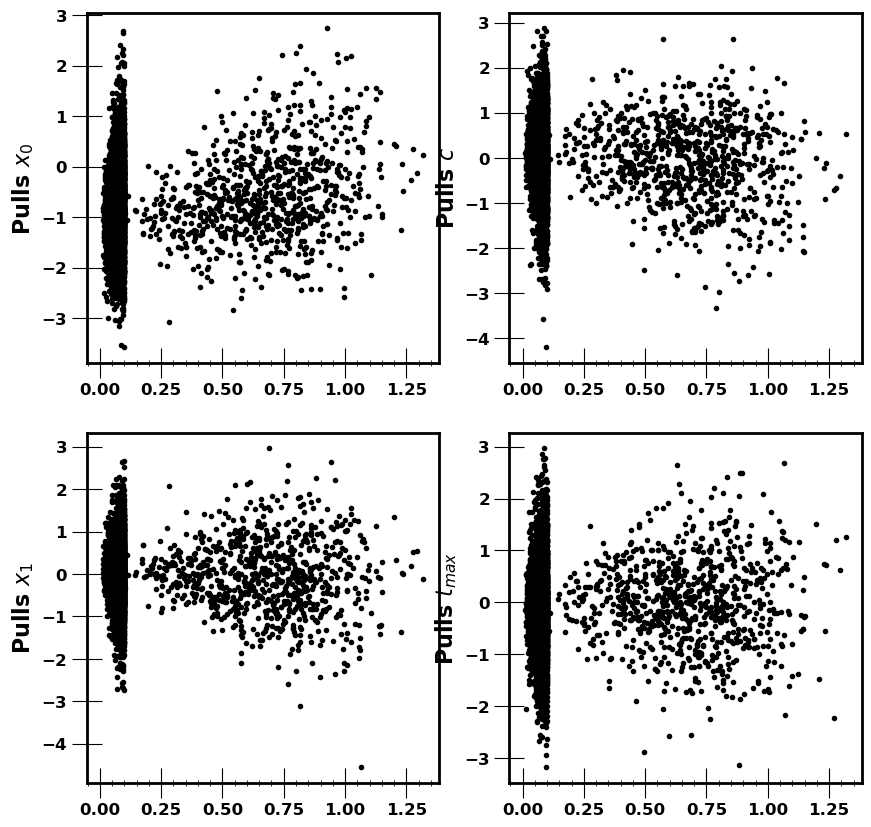

In [428]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
sty = dict(marker='.', color='k')
axs[0, 0].scatter(sn_pars.z,
                   (sn_pars.x0 - sn_pars.x0_init)/sn_pars.x0_err,
                   **sty)
axs[0, 1].scatter(sn_pars.z,
                   (sn_pars.x1-sn_pars.x1_init)/sn_pars.x1_err,
                   **sty)
axs[1, 0].scatter(sn_pars.z,
                   (sn_pars.c-sn_pars.c_init)/sn_pars.c_err,
                   **sty)
axs[1, 1].scatter(sn_pars.z,
                   (sn_pars.tmax-sn_pars.tmax_init)/sn_pars.tmax_err,
                   **sty)

axs[0, 0].set_ylabel(r'Pulls $x_0$')
axs[1, 0].set_ylabel(r'Pulls $x_1$')
axs[0, 1].set_ylabel(r'Pulls $c$')
axs[1, 1].set_ylabel(r'Pulls $t_{max}$')


In [53]:
from nacl.io.pickle import load_pickle

In [54]:
fit = load_pickle('/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/distillate.pkl.zst')

2025-08-14 14:46:50 INFO root - sparse_dot_mkl found. Building hessian should be faster.
2025-08-14 14:46:50 INFO nacl.minimize - sparse_dot_mkl found. Building hessian should be faster.


2025-08-14 14:47:46 WARNING py.warnings - /cfs/home/angi0819/Projet-LPNHE/sn-nacl/nacl/plotting/snpars.py:220: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])



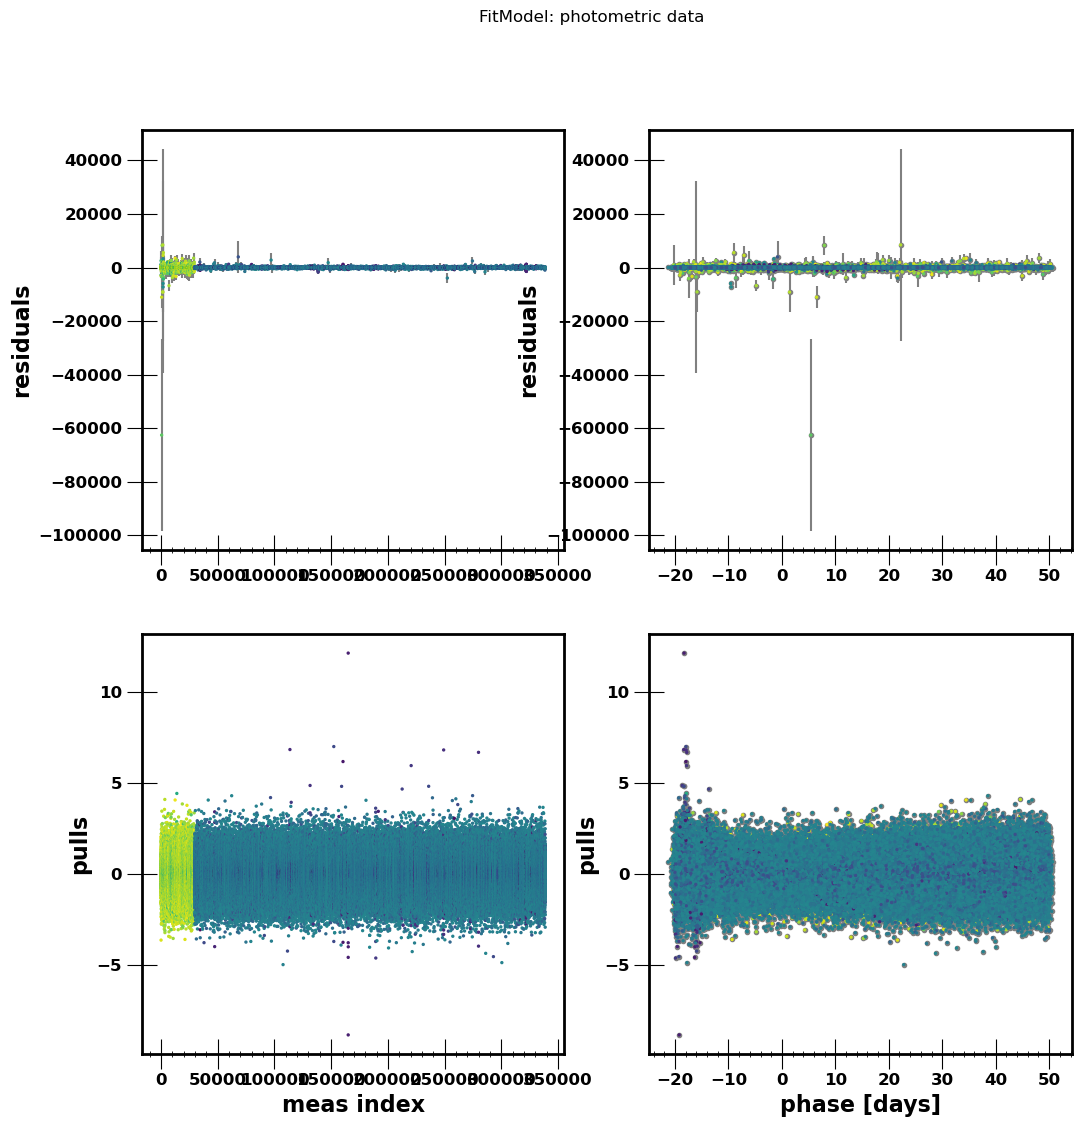

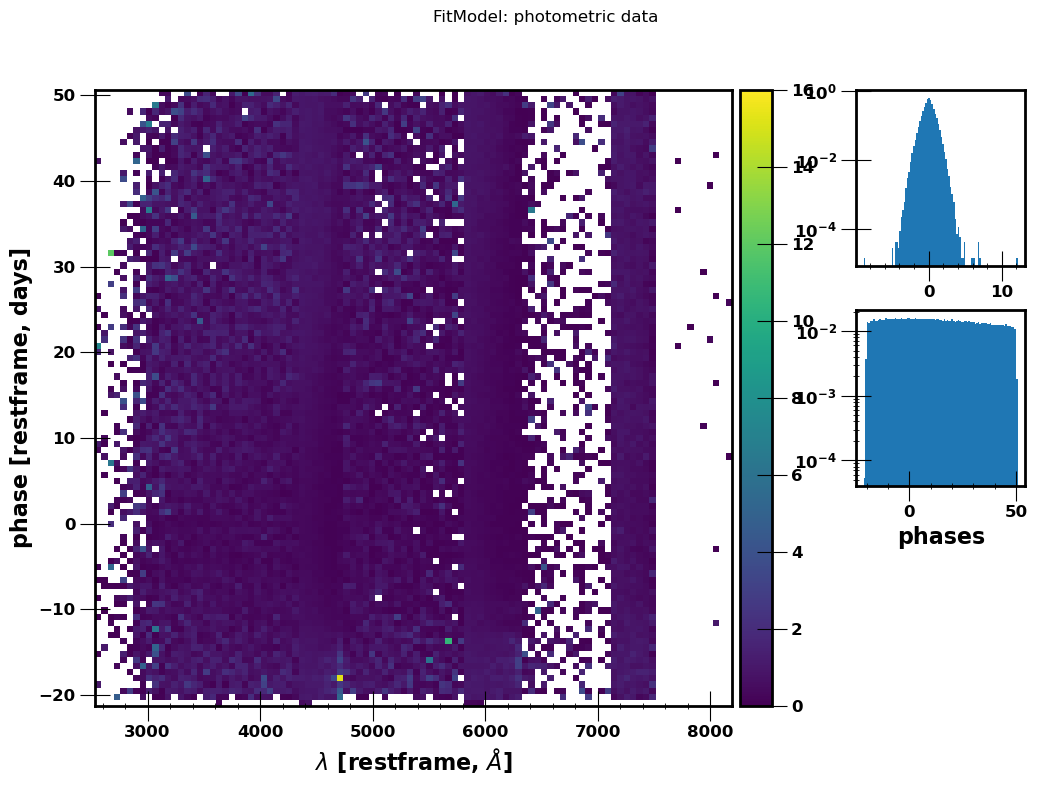

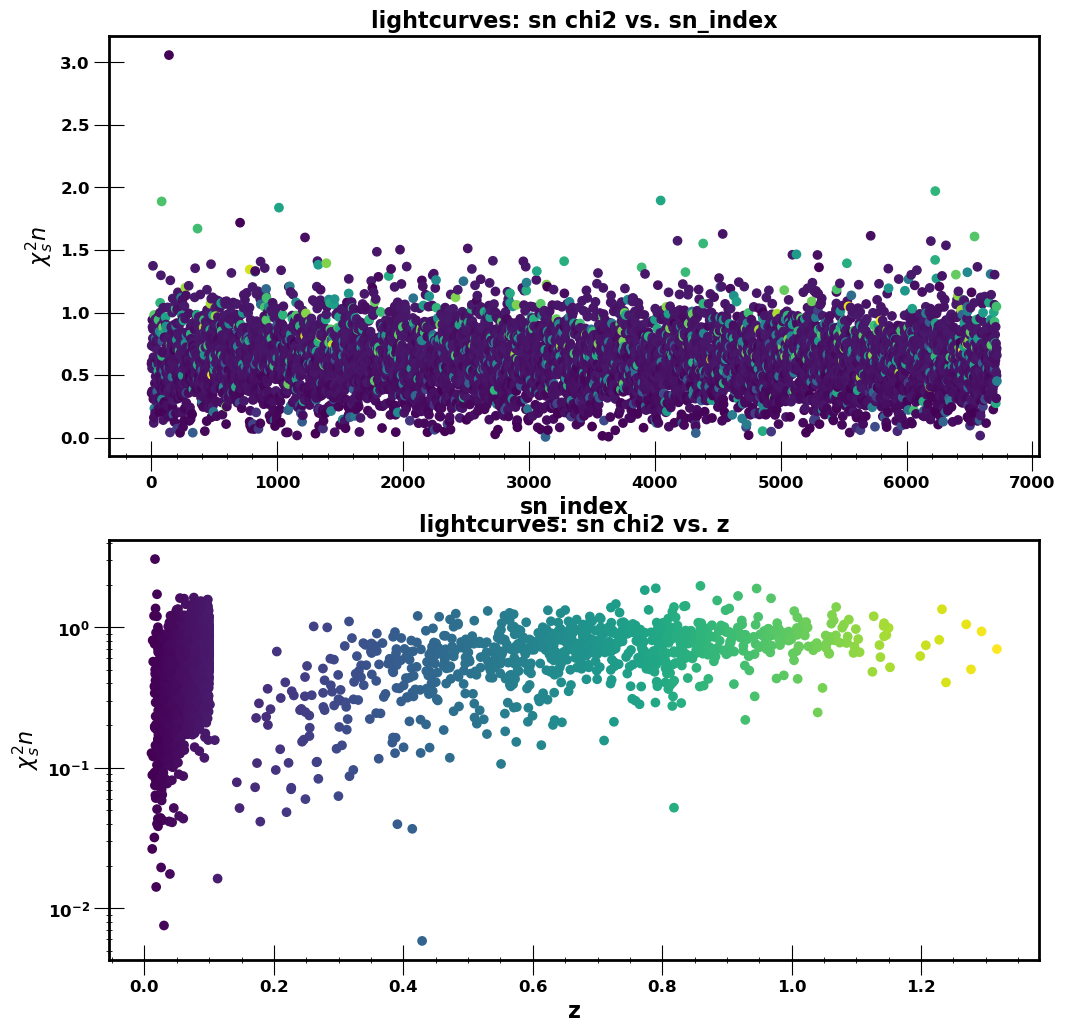

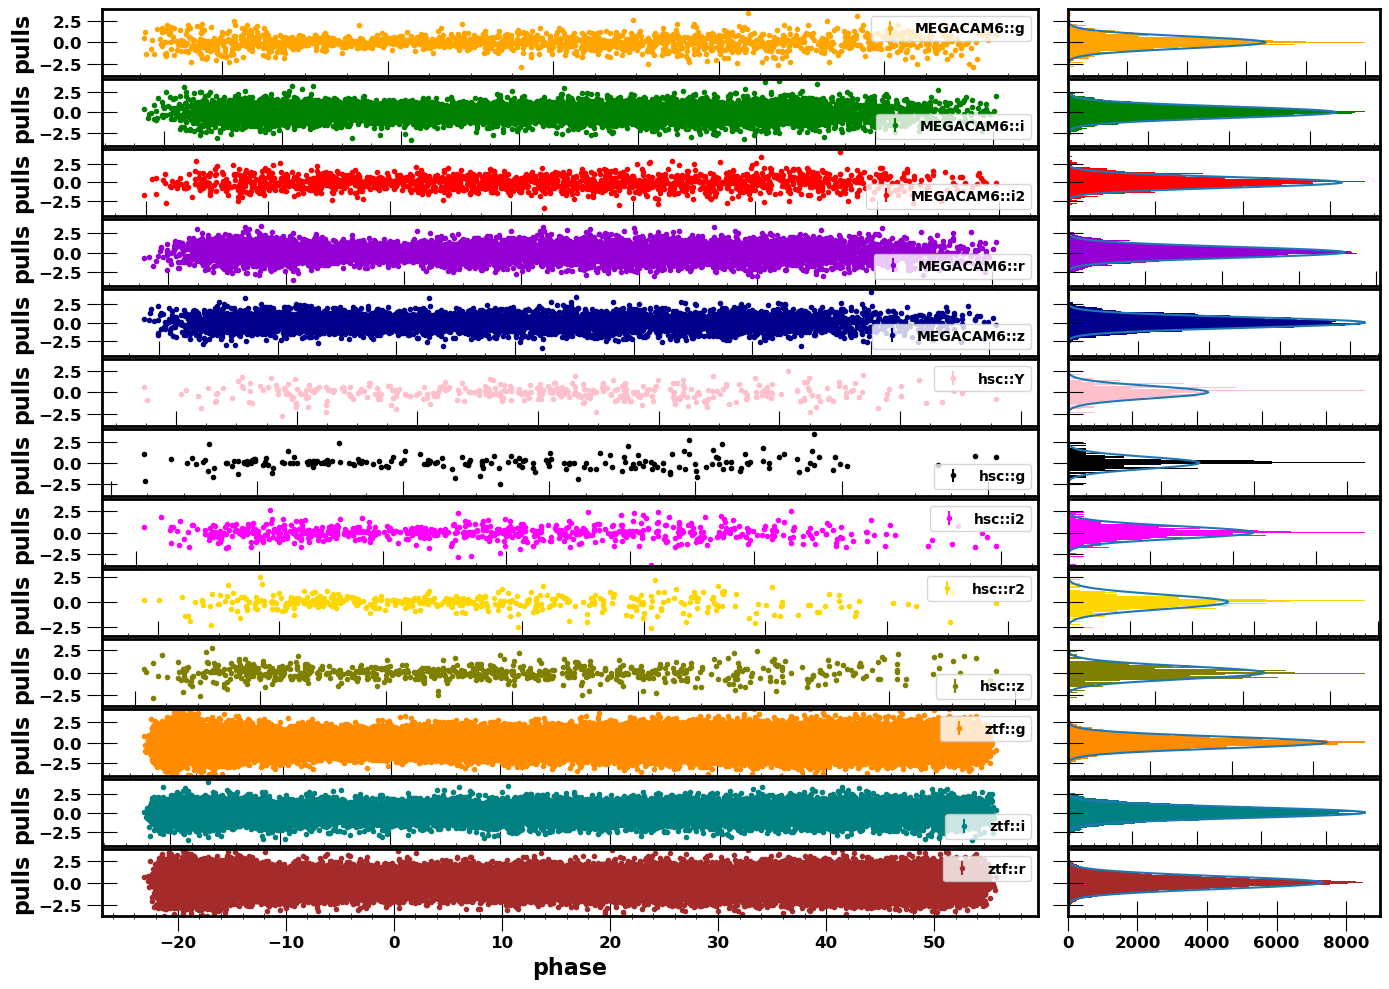

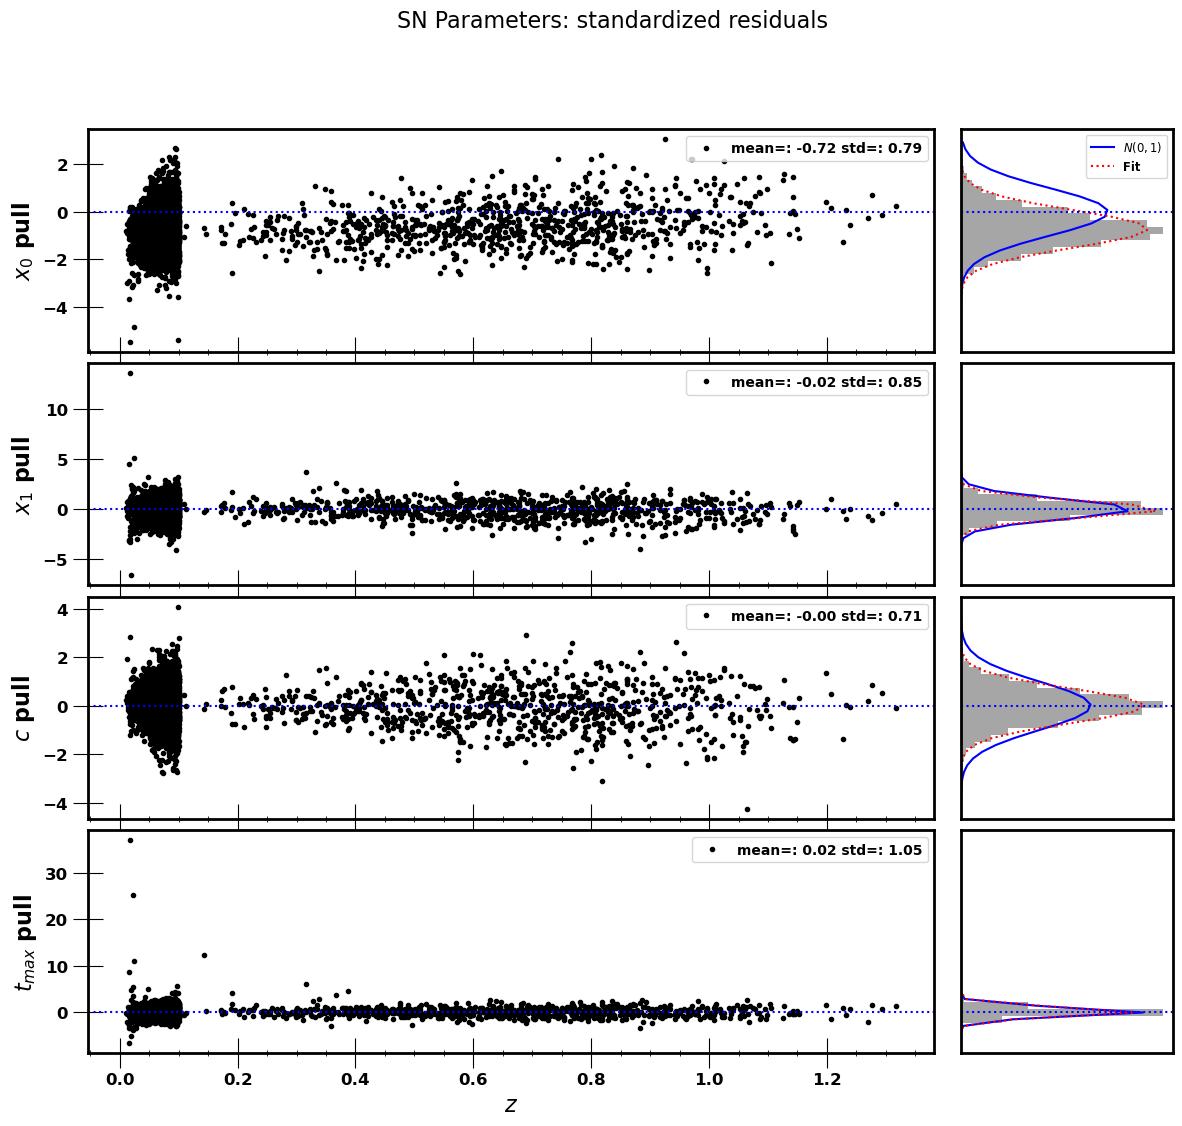

In [55]:
fit.plot(output_dir='/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/')

In [362]:
sn_pars[~sn_pars.name.isin(np.unique(tds.lc_data.sn))]

,index,name,z,tmax_init,x1_init,x0_init,c_init,mwebv,valid,IAU,survey,x0,x1,c,tmax,x0_err,x1_err,c_err,tmax_err
name,,,,,,,,,,,,,,,,,,,
ZTF_401,169,ZTF_401,0.062042,58466.363281,-0.110,0.000570,0.180,0.044938,1,None,ZTF,0.000549,0.266661,0.157629,58467.161128,5.960433e-05,0.466905,0.073295,0.545181
ZTF_467,198,ZTF_467,0.052796,58406.585938,0.185,0.002194,-0.084,0.046432,1,None,ZTF,0.002227,-0.048192,-0.106516,58406.740020,2.424334e-04,0.349075,0.070710,0.333974
ZTF_642,278,ZTF_642,0.085029,59038.738281,0.650,0.000325,0.238,0.091858,1,None,ZTF,0.000346,0.557757,0.185048,59038.012473,1.595887e-05,0.200263,0.025203,0.538918
ZTF_1263,552,ZTF_1263,0.094446,58958.566406,0.485,0.000312,0.117,0.034966,1,None,ZTF,0.000291,1.262510,0.150237,58958.327626,1.472001e-05,0.448950,0.039155,0.888692
ZTF_1284,561,ZTF_1284,0.042479,58830.781250,-1.665,0.001321,0.111,0.025990,1,None,ZTF,0.001407,-1.216410,0.064747,58828.955497,9.066341e-05,0.241587,0.046057,0.830985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSC_10400,11594,HSC_10400,0.190750,57802.250000,0.425,0.000105,-0.035,0.022329,1,None,HSC,0.000108,0.465009,-0.068973,57802.480642,8.360448e-06,0.211636,0.044353,0.138831
HSC_16200,11744,HSC_16200,0.390450,58810.460938,-0.105,0.000023,-0.124,0.028880,1,None,HSC,0.000022,-0.189491,-0.107294,58810.898268,1.104027e-06,0.255750,0.029771,0.515173
HSC_18370,11815,HSC_18370,0.658050,57744.082031,-0.425,0.000005,-0.047,0.024074,1,None,HSC,0.000005,-0.664575,-0.086757,57743.591067,2.423355e-07,0.240885,0.030333,0.514597


In [337]:
submit_results = [delayed(fit_sn)(sn, Table.from_pandas(lc_data.loc[sn]),
                                  sn_data.loc[sn,'z'],
                                  sn_data.loc[sn,'mwebv'],
                                  model,
                                  modelcov=True)
                    for sn in tqdm(sn_pars.name, desc='Creating delayed objects')]

Creating delayed objects:   0%|          | 0/6719 [00:00<?, ?it/s]

KeyError: 'ZTF_401'

In [272]:
futures_results = client.compute(submit_results)
progress(futures_results)

2025-08-14 16:11:53 WARNING py.warnings - /cfs/home/angi0819/conda/envs/lemaitre/lib/python3.12/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 46.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(



VBox()

2025-08-14 16:13:43,592 - distributed.worker - ERROR - Compute Failed
Key:       fit_sn-dd111994-696c-44fa-87b5-a1669232d646
State:     executing
Task:  <Task 'fit_sn-dd111994-696c-44fa-87b5-a1669232d646' fit_sn(..., ...)>
Exception: 'TypeError("\'tuple\' object does not support item assignment")'
Traceback: '  File "/tmp/ipykernel_62999/3239846012.py", line 33, in fit_sn\n'



In [273]:
res_ = client.gather(futures_results, errors='skip')

In [274]:
res = pandas.concat(res_)

In [275]:
res["survey"] = list(map(lambda x: x.split("_")[0], np.array(res.index)))

In [276]:
def build_cov_from_df(res):
    cov = np.zeros((3,3, len(res)))
    for i, k1 in enumerate(['x0', 'x1', 'c']):
        for j, k2 in enumerate(['x0', 'x1', 'c']):
            if i <= j:
                cov[i,j,...] = cov[j,i,...] = res['cov_' + k1 + '_' + k2]
    return cov.T

In [277]:
covs = build_cov_from_df(res)

In [278]:
test = (np.identity(3)[..., None] @ np.ones(len(res))[None, None,...])
test[0, 0] =  -2.5 / (np.log(10) * res["x0"].values)
test=test.T

In [279]:
new_covs=np.matmul(test, np.matmul(covs, test))

In [280]:
res['Mb_err']=np.sqrt(new_covs[...,0,0])
res['Mb'] = -2.5*np.log10(res['x0'])

In [281]:
res['mu'] = res.Mb + 0.14*res.x1 - 3.15*res.c
to_mu = (np.array([[1, 0.14, -3.15]])[..., None] @ np.ones(len(res))[None, None,...]).T

In [282]:
res['mu_err'] = np.sqrt(np.matmul(to_mu.transpose((0, 2, 1)), np.matmul(new_covs, to_mu)).reshape(-1))

In [283]:
res['t0_true'] = sn_data.tmax
res['x0_true'] = sn_data.x0
res['x1_true'] = sn_data.x1
res['c_true'] = sn_data.c

In [284]:
bounds={"x0":np.array([-1., 10.]),
       "x1":np.array([-4., 4.]),
       "c": np.array([-0.4, 1.2])}

In [297]:
res.to_pickle('/cfs/data/angi0819/Projet_LPNHE/salt_fit_modelcov.pkl')

In [298]:
stuck_x1 = np.any(np.abs(bounds["x1"][None,...] - res.x1.values[...,None]) < 0.01*np.diff(bounds["x1"]), axis=1)
stuck_c  = np.any(np.abs(bounds["c"][None,...]  - res.c.values[...,None])  < 0.01*np.diff(bounds["c"]),  axis=1)
stuck_x0 = np.any(np.abs(bounds["x0"][None,...] - res.x0.values[...,None]) < 0.01*np.diff(bounds["x0"]), axis=1)
not_stuck =  ~(stuck_x1 | stuck_c | stuck_x0)

chi2_cut = (res.chisq/res.ndof < 3) & (res.ndof > 0)
x1_cut = res.x1.between(-3, 3)
c_cut = res.c.between(-0.2, 0.8)
sigma_t0 = (res.t0_err < 1)
sigma_x1 = (res.x1_err < 1)
sigma_c = (res.c_err < 1)

In [299]:
total_cut = res.t0 > 0
print(f"\t\tSNe kept\tCut")
print(f"Total\t\t{total_cut.sum()}\t\t-")

for cut in ["not_stuck", "chi2_cut", "x1_cut", "c_cut", "sigma_t0", "sigma_x1", "sigma_c"]:
    print(cut+f"   \t{(total_cut & eval(cut)).sum()}\t\t{total_cut.sum()-(total_cut & eval(cut)).sum()}")
    total_cut &= eval(cut)
print("-"*36)
print(f"Total\t\t{total_cut.sum()}\t\t{(~total_cut).sum()}")
res.loc[~total_cut, "success"] = False    

		SNe kept	Cut
Total		8108		-
not_stuck   	7935		173
chi2_cut   	7836		99
x1_cut   	7724		112
c_cut   	7654		70
sigma_t0   	6736		918
sigma_x1   	6393		343
sigma_c   	6393		0
------------------------------------
Total		6393		1715


In [300]:
print('\tTotal\tGoods')
for s in res.survey.unique():
    print(s +f"\t{(res.survey==s).sum()}\t{(res.success & (res.survey==s)).sum()}")

	Total	Goods
HSC	241	39
SNLS	911	334
ZTF	6956	6020


### Edris

In [6]:
from edris.georgesutils import *

In [7]:
cuts = {"redshift range": "(z > 0.015) & (z < 1.23)",
        "x1 range": "np.abs(x1) < 3",
        "color range": "np.abs(c) < 0.3",
        "color error": "ec < 0.1",
        "stretch error": "ex1 < 2.",
        "time sampling": "etmax < 2."}

sigma_int = 0.15
z_bins = jnp.array([0.015, 0.024, 0.034, 0.044, 0.05 , 0.055, 0.059, 0.064, 0.069,
       0.074, 0.082, 0.129, 0.177, 0.225, 0.273, 0.331, 0.389, 0.446,
       0.493, 0.531, 0.572, 0.603, 0.635, 0.665, 0.689, 0.713, 0.732,
       0.765, 0.787, 0.808, 0.838, 0.879, 0.929, 0.988, 1.234])
mini_pars = {"niter": 1000,
             "lmbda": 10000.0,
             "tol": 0.01,
             "verbose": True}


In [8]:
nacl_fitres = load_nacl_output("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars.parquet", "/cfs/data/angi0819/Projet_LPNHE/nacl_cli/1_lcfit/nacl_sn_pars_cov.npy")
selected_inputs = apply_selection(*nacl_fitres, cuts=cuts)
edris_inputs = prepare_edris_inputs(*selected_inputs)
explanatory = edris_inputs[0]


Initial number | 6507 | 100.00\% \\
redshift range | 6494 | 99.80\% \\
x1 range | 6484 | 99.65\% \\
color range | 6112 | 93.93\% \\
color error | 6111 | 93.91\% \\
stretch error | 6111 | 93.91\% \\
time sampling | 6111 | 93.91\% \\


In [9]:
explanatory['sigma_int'] = sigma_int
explanatory['z_bins'] = z_bins

In [10]:
import edris
initial_guess = edris.models.starting_point(explanatory, edris_inputs[1], coef=[-.1, 3.14])

In [11]:
L = lambda x: edris.models.likelihood(x, *edris_inputs, truncated=False, restricted=False)
_L = edris.tools.restrict(L, fixed_params={'sigma_int': explanatory['sigma_int']})
res, loss, lmbda, iter_params = edris.minimize.tncg(_L, initial_guess, **mini_pars)


iter 0/1000. Loss: -1.8e+04->-1.9e+04(-5.9e+02), ρ=0.68, λ=10000.0
iter 1/1000. Loss: -1.9e+04->-1.9e+04(-2.1e+02), ρ=0.90, λ=3000.0
iter 2/1000. Loss: -1.9e+04->-1.9e+04(-3.1e+02), ρ=0.82, λ=900.0
iter 3/1000. Loss: -1.9e+04->-2e+04(-2.3e+02), ρ=0.71, λ=900.0
iter 4/1000. Loss: -2e+04->-2e+04(-48), ρ=0.76, λ=270.0
iter 5/1000. Loss: -2e+04->-2e+04(-33), ρ=0.80, λ=81.0
iter 6/1000. Loss: -2e+04->-2e+04(-46), ρ=0.88, λ=24.3
iter 7/1000. Loss: -2e+04->-2e+04(-62), ρ=0.82, λ=7.29
iter 8/1000. Loss: -2e+04->-2e+04(-49), ρ=0.74, λ=7.29
iter 9/1000. Loss: -2e+04->-2e+04(-13), ρ=0.78, λ=2.187
iter 10/1000. Loss: -2e+04->-2e+04(-6.3), ρ=0.67, λ=2.187
iter 11/1000. Loss: -2e+04->-2e+04(-0.83), ρ=0.70, λ=2.187
iter 12/1000. Loss: -2e+04->-2e+04(-0.14), ρ=0.71, λ=2.187
iter 13/1000. Loss: -2e+04->-2e+04(-0.025), ρ=0.72, λ=2.187
iter 14/1000. Loss: -2e+04->-2e+04(-0.0051), ρ=0.73, λ=2.187
converged in 14 iterations
Completed in 20.65min


In [572]:
def unflatten_stacked_vectors(p, sv, axis=0):
    '''
    Give a (n,m) matrix sv the same pytree structure as p, but contrary to unflatten_matrix it broadcasts the second axis m to a new one for each leaves
    (hence the name unflatten_stacked_vectors, because the matrix should be seen as a stack of vector and not as a proper (n,n) matrix).
    If a leaf in the input tree has shape $(i_0, i_1, ..., i_k)$ then the resulting leaf has shape $(..., i_{axis-1}, m, i_{axis},...)$.

    Parameters
    ----------
    p: pytree
        Reference pytree whose structure will be used (including the leaf dimension)
    sv: (n,m) Array
        Matrix to cast into the pytree form

    Example
    -------
      >>> p = {"a":jnp.array([1]), "b":jnp.array([[2], [3]])}
      >>> sv = jnp.array([[1., 1.], [2., 2.], [3., 3.]])
      >>> unflatten_stacked_vectors(p, sv)
          {'a': Array([[1.],
                [1.]], dtype=float64),
           'b': Array([[[2.],
                   [3.]],
                
                  [[2.],
                   [3.]]], dtype=float64)}
      >>> unflatten_stacked_vectors(p, sv, axis=1)
          {'a': Array([[1., 1.]], dtype=float64),
           'b': Array([[[2.],
                   [2.]],
         
                  [[3.],
                   [3.]]], dtype=float64)}
    '''
    leaves, struct = jax.tree.flatten(p)
    dims_leaves = [jnp.shape(a) for a in leaves]
    tot_size_leaves = jnp.array(jax.tree.map(lambda a : jnp.prod(jnp.array(a)), dims_leaves, is_leaf=lambda x: isinstance(x, tuple)))
    if sv.shape[0] != tot_size_leaves.sum():
        raise ValueError(f"First dimension of sv, doesn't match the leaves total length, {sv.shape[0]} != {tot_size_leaves.sum()}")
    bounds = jnp.cumsum(jnp.array([0, *tot_size_leaves]))
    return jax.tree.unflatten(struct, [jnp.moveaxis(sv[start:end, :].reshape(*l_shape, -1), -1, axis) for start, end, l_shape in zip(bounds[:-1], bounds[1:], dims_leaves)])

def flatten_except_axis(a, axis=0):
    '''
    Flatten a given array except along one axis which is preserved
    
    Parameters
    ----------
    a : Array
        Array to flatten
    axis : int
        Axis to keep
    '''
    if a.ndim < 2:
        return a
    else:
        shp = a.shape
        return jnp.moveaxis(a, axis, 0).reshape(shp[axis], -1)

def flatten_stacked_vectors(p, axis=0):
    '''
    Transforms a stack of m vectors in a pytree structure into a standard matrix (n,m).
    
    Example
    -------
    >>> flatten_stacked_vectors({'a': jnp.array([[1.], [1.]]),
                                 'b': jnp.array([[[2.],[3.]],[[2.],[3.]]])}, axis=0)
        Array([[1., 2., 3.],
               [1., 2., 3.]], dtype=float64)
    '''
    return jnp.concatenate([flatten_except_axis(p[v], axis=axis) for v in p], axis=-1).T

In [442]:
vec_hvp = jax.vmap(hvp, in_axes=(0), out_axes=(0))

In [446]:
test_id = unflatten_stacked_vec(res, idmat)

In [447]:
test_ = vec_hvp(test_id)

In [451]:
hessian = flatten_stacked_vec(test_, 0)

In [578]:
from edris.tools import flatten_vector

def better_get_hessian(likelihood, params):
    '''Hessian matrix computation with the hessian-vector product technique
        (but vectorized and much faster than the previous implementation)
    
    Parameters:
    -----------
    
    likelihood: (func) the function of params which the hessian is
                computed

    params: (pytree) the working point at which the hessian is
            computed
    '''


    hvp = lambda v: edris.tools.hessian_vector_product(likelihood, params, v)
    hvp = jax.jit(hvp)
    
    vec_hvp = jax.vmap(hvp, in_axes=(-1), out_axes=(0))
    
    Nparams = len(flatten_vector(params))
    idmat = jnp.eye(Nparams)
    # Gives the identity matrix the same structure as the params, considering it as a collection of columns
    idmat_unflattened = unflatten_stacked_vectors(params, idmat, axis=-1)

    hessian_unflattened = vec_hvp(idmat_unflattened)
    
    return flatten_stacked_vectors(hessian_unflattened, 0)

In [ ]:
hessian_columns = []
for i in tqdm(range(1000), desc='Computation of hessian column'):
    column = hvp(unflatten_vector(res, idmat[:,i]))
    flatten_column = flatten_vector(column)
    hessian_columns.append(flatten_column)


Computation of hessian column:   0%|          | 0/1000 [00:00<?, ?it/s]

### Cosmologix

In [1]:
import cosmologix

In [25]:
with open("/cfs/data/angi0819/Projet_LPNHE/nacl_cli/cosmologix/grid_fwcdm_cmb.pkl", 'rb') as file:
    data=pickle.load(file)

In [26]:
data

{'params': ['Omega_bc', 'w'],
 'x': Array([0.18      , 0.18508475, 0.19016949, 0.19525424, 0.20033898,
        0.20542373, 0.21050847, 0.21559322, 0.22067797, 0.22576271,
        0.23084746, 0.2359322 , 0.24101695, 0.24610169, 0.25118644,
        0.25627119, 0.26135593, 0.26644068, 0.27152542, 0.27661017,
        0.28169492, 0.28677966, 0.29186441, 0.29694915, 0.3020339 ,
        0.30711864, 0.31220339, 0.31728814, 0.32237288, 0.32745763,
        0.33254237, 0.33762712, 0.34271186, 0.34779661, 0.35288136,
        0.3579661 , 0.36305085, 0.36813559, 0.37322034, 0.37830508,
        0.38338983, 0.38847458, 0.39355932, 0.39864407, 0.40372881,
        0.40881356, 0.41389831, 0.41898305, 0.4240678 , 0.42915254,
        0.43423729, 0.43932203, 0.44440678, 0.44949153, 0.45457627,
        0.45966102, 0.46474576, 0.46983051, 0.47491525, 0.48      ],      dtype=float64),
 'y': Array([-0.        , -0.02542373, -0.05084746, -0.07627119, -0.10169492,
        -0.12711864, -0.15254237, -0.1779661 , -0

In [22]:
mu = np.load('/cfs/data/angi0819/Projet_LPNHE/nacl_cli/edris/edris_mu.npy')
cov = np.load('/cfs/data/angi0819/Projet_LPNHE/nacl_cli/edris/edris_mu_cov.npy')

Omega_bc = 0.340 ± 0.054
Omega_k = -0.07 ± 0.14
M = -29.7327 ± 0.0052
χ²=25.92 (d.o.f. = 32), χ²/d.o.f = 0.810
p-value: 76.70%


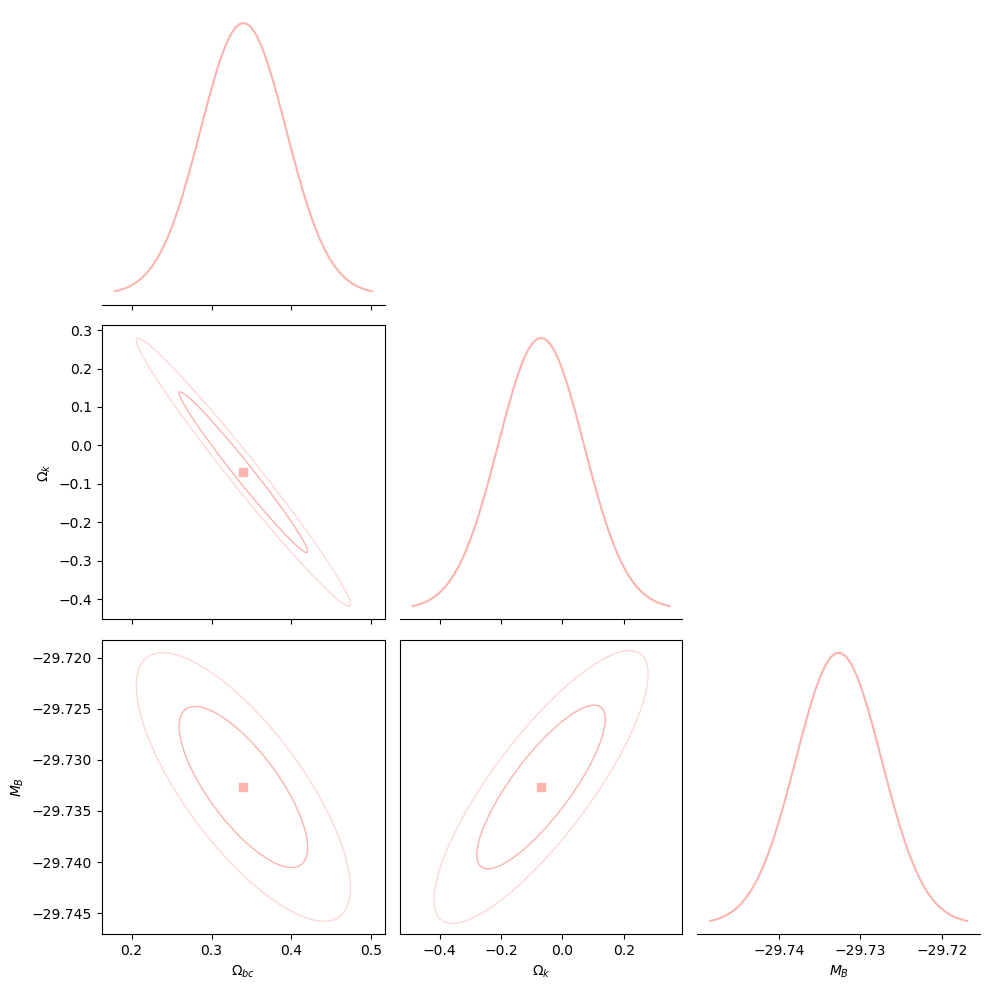

In [24]:
from cosmologix import cli
fit = cli.fit(prior_names=[], cosmology='LCDM', fix=[('H0', 70), ('Omega_b_h2', 0.02222)], mu=mu, mucov=cov, show=True)

Attention, Uchuu avec Planck15, Abacus avec Planck18

In [ ]:
plt.rc("axes", labelsize=20)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=14)  # fontsize of the tick labels
plt.rc("ytick", labelsize=14)  # fontsize of the tick labels
plt.rc("legend", fontsize=12)  # legend fontsize

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
keys = np.array(list(res.keys()))[[p in potential_keys for p in res.keys()]]
_labels, _values, _diffs = [], [], []
for k in keys:
    _labels += latex_keys[k] if isinstance(latex_keys[k], list) else [latex_keys[k]]
    _values += list(res[k])
    _diffs += list(res[k] - x0[k])
n_pars = len(keys)
ax.hlines(0, -1, 5 * n_pars + 1, color="r", linestyle=":")
ax.set_xticks(5 * np.arange(n_pars + 1), _labels)
ax.set_ylabel("Deviation")
plt.errorbar(
    5 * np.arange(n_pars + 1),
    _diffs,
    yerr=jnp.sqrt(jnp.diag(cov_res)[: n_pars + 1]),
    linestyle="",
    marker=".",
    capsize=5,
    capthick=0.5,
)
# plt.savefig('../figures/Uchuu_final_params.png')
fig, ax = plt.subplots(figsize=(1, 1))
ax.axis("off")
for i, pos in enumerate(np.arange(n_pars + 1) * 0.4):
    fig.text(
        0,
        pos,
        _labels[i] + f" = {_values[i]:.3f} $\\pm$ {jnp.sqrt(jnp.diag(cov_res)[i]):.3f}",
    )

In [ ]:
def plot_hubble(obs, res, cov_res, cosmo, x0):
    std_mag = obs.mag - jnp.matmul(res["coef"], res["variables"])

    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex="col", figsize=(7, 6), gridspec_kw={"height_ratios": [3, 1]}
    )
    ax1.set_xscale("log")
    ax1.scatter(
        exp["z"], std_mag, s=0.5, alpha=0.3, color="k", label="Standardised magnitudes"
    )
    ax1.plot(
        np.linspace(5e-3, 1.2, 1000),
        cosmo(x0, {"z": np.linspace(5e-3, 1.2, 1000)}),
        color="tab:green",
        linestyle=":",
        label="Underlying cosmo",
    )

    ax2.scatter(exp["z"], std_mag - cosmo(x0, exp), color="k", s=0.5, alpha=0.3)

    if "mu_bins" in res.keys():
        ax1.errorbar(
            exp["z_bins"],
            res["mu_bins"],
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
            label="edris",
        )
        ax2.errorbar(
            exp["z_bins"],
            res["mu_bins"] - cosmo(x0, {"z": exp["z_bins"]}),
            yerr=jnp.sqrt(jnp.diag(cov_res[2 : 2 + n_bins, 2 : 2 + n_bins])),
            color="tab:blue",
        )
    else:
        ax1.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
            label="edris",
        )
        ax2.plot(
            jnp.linspace(5e-3, 1.2, 1000),
            cosmo(res, {"z": jnp.linspace(5e-3, 1.2, 1000)})
            - cosmo(x0, {"z": jnp.linspace(5e-3, 1.2, 1000)}),
            color="tab:blue",
        )

    ax1.legend()
    ax1.set_ylabel(r"$\mu$")

    lims = ax2.get_xlim()
    ax2.hlines(0.0, xmin=lims[0], xmax=lims[1], color="tab:green", linestyle=":")
    ax2.set_xlim(*lims)
    ax2.set_ylabel(r"$\Delta\mu$")
    ax2.set_xlabel(r"$z$")

    fig.suptitle(r"Modèle fitté par Edris")

In [ ]:
plot_hubble(obs, res, cov_res, flcdm, x0)

In [ ]:
mag_to_z = interp1d(
    flcdm(res, {"z": np.linspace(2e-3, 0.3, 10000)}), np.linspace(2e-3, 0.3, 10000)
)
z_cosmo_salt = mag_to_z(
    obs.mag[exp["survey_id"] == exp["survey_map"]["ZTF"]]
    - jnp.matmul(res["coef"], res["variables"])[
        exp["survey_id"] == exp["survey_map"]["ZTF"]
    ]
)

In [ ]:
data_ztf = data[data.index.isin(values[(values.survey == "ZTF") & filt].index)]
true_pv = (data_ztf.z - data_ztf.z_cosmo) * c * 1e-3 / (1 + data_ztf.z_cosmo)
edris_pv = (data_ztf.z - z_cosmo_salt) * c * 1e-3 / (1 + z_cosmo_salt)

z_max = 0.1
n_bins = 10
bounds = np.linspace(0.00, z_max, n_bins + 1)
width = z_max / n_bins
in_bins = [(data_ztf.z > z_min) & (data_ztf.z < z_min + width) for z_min in bounds]
plt.figure(figsize=(10, 6))

plt.scatter(data_ztf.z, edris_pv, marker=".", alpha=0.1, label="Reconstructed PV")
plt.scatter(
    data_ztf.z, true_pv, marker=".", color="tab:red", alpha=0.1, label="True PV"
)

plt.errorbar(
    bounds + width,
    [edris_pv[b_].mean() for b_ in in_bins],
    yerr=[edris_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="Mean Reconstructed PV",
)

plt.errorbar(
    bounds + width,
    [true_pv[b_].mean() for b_ in in_bins],
    yerr=[true_pv[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="red",
    linewidth=2,
    capsize=2,
    label="Mean True PV",
)

plt.xlabel("$z$")
plt.ylabel("$vp$")
plt.legend()
plt.axhline(0, color="k")

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(
    data_ztf.z,
    true_pv - edris_pv,
    marker=".",
    linestyle="",
    alpha=0.3,
    label="$vp_{vraie} - vp_{edris}$",
)
plt.errorbar(
    bounds + width,
    [(true_pv - edris_pv)[b_].mean() for b_ in in_bins],
    yerr=[(true_pv - edris_pv)[b_].std() for b_ in in_bins],
    xerr=width / 2,
    linestyle="",
    color="blue",
    linewidth=2,
    capsize=2,
    label="PV residuals",
)
plt.xlabel("$z$")
plt.ylabel(r"$\Delta pv$")
plt.axhline(0, color="k")
plt.axhline((true_pv - edris_pv).values.mean(), color="r", linestyle=":", label="Mean")
plt.axhline(
    (true_pv - edris_pv).values.mean() + (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
    label="std",
)
plt.axhline(
    (true_pv - edris_pv).values.mean() - (true_pv - edris_pv).values.std(),
    color="r",
    linestyle="--",
)

plt.legend()

In [ ]:
(true_pv - edris_pv).values.mean(), (true_pv - edris_pv).values.std()

# Power spectrum stuff

In [ ]:
from cosmoprimo import *
cosmo_p = Cosmology(engine='camb')
cosmo_planck = fiducial.Planck2018FullFlatLCDM()

In [ ]:
fo = Fourier(cosmo_p, engine='class')
pk = fo.pk_interpolator()
k = np.logspace(-6, 2, 1000)
z = 0
plt.loglog(k, pk(k, z=z), label='class')
fo_camb = cosmo_p.get_fourier(engine='camb') # second initialisation style
pk = fo_camb.pk_interpolator() # same number of cells are output than in CLASS
plt.loglog(k, pk(k, z=z), label='camb')
# cross density-velocity CDM + baryon power spectrum
plt.loglog(k,fo.pk_interpolator(of=('theta_cb', 'theta_cb'))(k, z=z), label=r'$P_{\delta_{cb}\theta_{cb}}$')
plt.loglog(k,fo.pk_interpolator(of=('theta_m', 'theta_m'))(k, z=z), label=r'$P_{\theta_{m}\theta_{m}}$')
plt.xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

In [ ]:
k, p = np.loadtxt('test')

In [ ]:
with open("./outdir/ztf_2M++_snls_hsc_DR2cuts.pkl", "rb") as file:
    values=pickle.load(file)
    covs=pickle.load(file)

In [ ]:
data_ztf,_ = load_from_skysurvey('./data/dataset_2M++.pkl', survey='ZTF')
data_hsc,_ = load_from_skysurvey('./data/dataset_hsc.pkl', survey='HSC')
data_snls,_ = load_from_skysurvey('./data/dataset_snls.pkl', survey='SNLS')
data=pandas.concat([data_ztf, data_hsc, data_snls])

In [ ]:
values = values.join(data[['ra','dec']])
values.ra = (values.ra/180-1)*np.pi
values.dec = values.dec/180*np.pi

In [ ]:
values["rcom"] = cosmo.comoving_distance(values.z).value
values.sort_values('z', inplace=True)

In [ ]:
from flip import covariance, utils
coordinates = np.array([values['ra'],
                        values['dec'],
                        values['rcom']])
sigmau_fiducial = 15

power_spectrum_dict = {"vv": [[k, p * utils.Du(k, sigmau_fiducial) ** 2]]}

size_batch=10_000
number_worker=64

covariance_fit = covariance.CovMatrix.init_from_flip(
    "carreres23",
    "velocity",
    power_spectrum_dict,
    coordinates_velocity=coordinates,
    size_batch=size_batch,
    number_worker=number_worker,
)


In [ ]:
covariance_fit.compute_full_matrix()

In [ ]:
vpec_cov = (5/(c.value*1e-3*np.log(10)))**2*covariance_fit.covariance_dict['vv'][0] * \
            (np.array([1/values.z.values]).T @ \
             np.array([1/values.z.values]))

In [ ]:
from matplotlib.colors import SymLogNorm
fig, (ax_vv, ax_mm) = plt.subplots(figsize=(12,5), ncols=2)
im_vv = ax_vv.imshow(covariance_fit.covariance_dict['vv'][0], norm=SymLogNorm(linthresh=1e3))
plt.colorbar(im_vv, ax=ax_vv, label=r'$(km/s)^2$')
ax_vv.set_title(r'$Cov_{vv}$')
im_mm = ax_mm.imshow(vpec_cov, norm=SymLogNorm(linthresh=1e-7))
plt.colorbar(im_mm, ax=ax_mm, label=r'$mag^2$')
ax_mm.set_title(r"$Cov_{mm}$")

In [ ]:
plt.scatter(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]],
            true_pv[filt] - edris_vp,
            marker=".",
            linestyle='',
            alpha=0.3,
            label="$vp_{vraie} - vp_{edris}$")
mean_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                         (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].mean()
              for z_min in np.linspace(0.00, 0.05, 6)]
err_delta = [(true_pv[filt] - edris_vp).values[(exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] > z_min) & \
                                        (exp['z'][exp["survey_id"] == exp['survey_map']["ZTF"]] < z_min + 0.01)].std()
             for z_min in np.linspace(0.00, 0.05, 6)]
plt.errorbar(np.linspace(0.00, 0.05, 6)+0.005,
             mean_delta,
             yerr=err_delta,
             xerr=0.005,
             linestyle='',
             color='tab:red',
             linewidth=2,
             capsize=2,
             label="Moyenne")

plt.xlabel("$z$")
plt.ylabel("$\Delta vp$")
plt.legend()
plt.ylim(-4000,4000)
plt.axhline(0, color='k')

In [ ]:
(true_pv[filt] - edris_vp).values.mean()